# Exact and Approximate Bayesian Inference

## -- Kai Chang

In this write-up, we explore several "workhorse" algorithms in Bayesian inference, including the Markov Chain Monte Carlo (MCMC), the adaptive Metropolis-Hastings, the Kalman filter, and the ensemble Kalman filter. The algorithms are applied on two representative problems in Bayesian inverse problems: inferring the diffusivity in a stochastic diffusion equation given a sparse set of observations, and estimating the states in the chaotic Lorentz-63 system. Extensvie numerical experiments are conducted, and various evaluation metrics are considered to show the algorithmic performance.

To begin with, we first implement the numerical solver of the 1-D diffusion equation. 

In [1]:
import numpy as np
"""
Solve 1-D diffusion equation with given diffusivity field k
and left-hand flux F.

ARGUMENTS: 
    xgrid = vector with equidistant grid points
        F = flux at left-hand boundary, k*du/dx = -F 
   source = source term, either a vector of values at points in xgrid
            or a constant
  rightbc = Dirichlet BC on right-hand boundary
Domain is given by xgrid (should be [0,1])
"""
def diffusioneqn(xgrid, F, k, source, rightbc):
    N = len(xgrid)
    h = xgrid[N-1] - xgrid[N-2]
    
    A = np.zeros((N-1, N-1))
    b = np.zeros(N-1)
    
    if isinstance(source, (int, float)):
        f = -source * np.ones(N-1)
    else:
        f = -source[:N-1]
    
    A -= np.diag(2*k[:-1] + k[1:] + np.insert(k[:-2],0,k[0]))
    A += np.diag(  k[:-2] + k[1:-1], 1)
    A += np.diag(  k[:-2] + k[1:-1],-1)
    A /= 2 * h**2
    
    A[0, 1] += k[0] / h**2
    b[0] = 2 * F / h
    
    b[N-2] = rightbc * (k[N-1] + k[N-2]) / (2 * h**2)
    
    uinternal = np.linalg.solve(A, f - b)
    usolution = np.append(uinternal, rightbc)
    
    return usolution


Codes for sampling from Karhunen-Loéve Expansion for a particular type of Gaussian Process.

In [2]:
""" 
KL-Expansion for GP
"""
def covfun(x1, x2, L=0.3, var_y=0.3):
    return var_y*np.exp(-np.abs(x1-x2)/L)

def form_KL_uniform(covfun, lo, hi, num_quad):
    pts, wts = np.polynomial.legendre.leggauss(num_quad)
    pts = (pts * (hi-lo)/2) + (hi + lo)/2
    wts *= (hi-lo)/2
    mesh1, mesh2 = np.meshgrid(pts, pts)
    C_mat = covfun(mesh1, mesh2)
    W_half = np.diag(np.sqrt(wts))
    A = W_half @ C_mat @ W_half
    lam, phi = np.linalg.eigh(A)
    psi = np.diag(1 / np.sqrt(wts)) @ phi
    lam = lam[::-1]
    psi = psi[:,::-1]
    psi = psi * (2*(psi[0,:] > 0) - 1)
    return lam, psi, pts, wts

class KLE:
    def __init__(self, lam, psi, pts, wts, covfun):
        self.lam = lam
        self.psi = psi
        self.pts = pts
        self.wts = wts
        self.covfun = covfun

def default_KLE(N_trunc, num_quad = 100):
    lam, psi, pts, wts = form_KL_uniform(covfun, 0., 1., num_quad)
    return KLE(lam[:N_trunc], psi[:,:N_trunc], pts, wts, covfun)

def eval_KLE(kl, xgrid, z = None):
    if z is None:
        rng = np.random.default_rng()
        z = rng.standard_normal(len(kl.lam))
    X,Y = np.meshgrid(kl.pts, xgrid)
    covmat = kl.covfun(X,Y) @ np.diag(kl.wts)
    psi_evals = covmat @ kl.psi @ np.diag(1/np.sqrt(kl.lam))
    return psi_evals @ z

def ExampleKLE():
    xgrid = np.linspace(0,1,101)
    n_trunc = 100
    kl = default_KLE(n_trunc, max(100, round(1.5*n_trunc)))
    rng = np.random.default_rng()
    z = rng.standard_normal(n_trunc)
    kl_eval = eval_KLE(kl, xgrid, z)
    return xgrid, kl_eval, z

xgrid, kl_eval, z = ExampleKLE()

Import data.

In [3]:
"""import ground truth k from .mat""" 
import scipy.io
diff_data = scipy.io.loadmat('ktrue.mat')
ktrue = diff_data['ktrue'].squeeze() # (151,)
xgrid = diff_data['xgrid'].squeeze() # (151,)
inference_data = scipy.io.loadmat('inferencedata.mat')
x_observed = inference_data['xobserved'].squeeze() # (10,)
u_observed = inference_data['Uobserved'].squeeze() # (10,)


Wrap the SDE solver and solve for the true $u(x)$ based on `ktrue`.

In [4]:
def sde_solve(k):
    F = -1
    RBC = 1
    SX = np.zeros((151,))
    DELTA = 0.05
    THETA = 0.8
    for m in [0.2,0.4,0.6,0.8]:
        SX += THETA / (DELTA * np.sqrt(2*np.pi)) * np.exp(-(xgrid-m)**2 / (2*DELTA**2))
    u = diffusioneqn(xgrid, F, k, SX, RBC)

    return u
u_true = sde_solve(ktrue)

Adjust customized plot settings.

In [3]:
# Plot settings
from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')
import seaborn as sns
sns.set()

## Bayesian Inverse Problem via MCMC
The estimation of spatially distributed properties from indirect data is important to a host of science and engineering applications, ranging from hydrology to materials processing. A classic example, arising in subsurface modeling, involves estimating a spatially varying permeability field $k(x)$ from limited and noisy observations of pressure.


In this problem, we want to infer the permeability $k(x)$ in the elliptic equation
$$
\frac{\partial}{\partial x}\left(k(x) \frac{\partial u(x)}{\partial x}\right)=-s(x), \quad x \in ,D=[0,1]
$$
from some noisy observations $y_i$ of $u(x_i)$ at some $x_i, 1\leq i \leq N$. The relationship between $y_i$ and $u(x_i)$ reads as 
$$
y_i=u\left(x_i\right)+\epsilon_i
$$
where $\epsilon_i \sim \mathcal{N}\left(0, \sigma_\epsilon^2\right)$ are i.i.d. Let $y = [y_1,y_2,\ldots,y_N]^T$. In the Bayesian setting, the goal is to infer and sample from the posterior distribution $ p(k(x) \,|\, y) $ from the likelihood model $ p(y\,|\,k(x))$ and the prior $p(k(x))$. To work with a finite-dimensional representation of $k(x)$, recall that $k(x):= \exp Y(x)$ where $Y(x)$ follows some Gaussian Process as defined in the instruction. By the (truncated) Karhunen-Loève Expansion, we can write 
$$
Y(x) \approx \mu(x)+\sum_{i=1}^r \sqrt{\lambda_i}\psi_i(x)Z_i,
$$
where $Z_i \sim \mathcal{N}\left(0, 1\right)$ are i.i.d. With this, we may reparameterize $k(x)$ with $Z = [Z_1, Z_2, \ldots, Z_r]^T$ and the dependence on $k(x)$ of the solution $u(x)$ is transferred on $Z$. We thus may instead try to infer the posterior distribution
$$
p(Z \,|\, y) \propto p(y \,|\, Z) p(Z)
$$
where 
$$
p(y \,|\, Z) = \mathcal{N}(u(x; Z), \sigma_{\epsilon}^2 I)
$$
and
$$p(Z) = \mathcal{N}(0,I).$$

With the key components gathered, we may derive the adaptive Metropolis-Hastings method as follows. The likelihood and the prior give the unnormalized posterior density
$$
\pi(Z) = \exp{\left(-\frac{Z^T Z}{2}\right)} \, \prod_{i=1}^N \exp{\left(-\frac{(y_i - u(x_i;Z))^2}{2\sigma_{\epsilon}^2}\right)}.
$$
The proposal $q(Z^{(n+1)} | Z^{(n)})$, based on the Adaptive Metropolis-Hastings method, is modeled as 
$$
q(Z^{(n+1)} | Z^{(n)}) = \mathcal{N}(Z^{(n)}, C_n)
$$
where $C_n = s_r \Sigma_n+\epsilon I_r$ with $s_r=2.4^2 / r$ being the rule-of-thumb scaling factor and $\epsilon > 0$. Note that we use $C_0 = \sigma_0^2 I$ for the first $n_0$ steps and switch to $C_n$ afterwards. Here, $\Sigma_n$ is the sample covariance which reads 
$$
\Sigma_n = \dfrac{1}{n-1}\sum_{i=1}^n(Z^{(i)} - \bar{Z_n})(Z^{(i)} - \bar{Z_n})^T,
$$
where $\bar{Z_n} = \dfrac{1}{n}\sum_{i=1}^n Z^{(i)}$. Note that $q(Z^{(n+1)} | Z^{(n)})$ and $q(Z^{(n)} | Z^{(n+1)})$ have the same variance and thus the proposal is symmetric. The acceptance ratio accordingly reads
$$
\alpha\left(Z^{(n)}, Z^{(n+1)}\right)=\min \left\{1, \frac{\pi(Z^{(n+1)}) q\left(Z^{(n)} \mid Z^{(n+1)}\right)}{\pi\left(Z^{(n)}\right) q\left(Z^{(n+1)} \mid Z^{(n)}\right)}\right\}=\min \left\{1, \frac{\pi(Z^{(n+1)})}{\pi\left(Z^{(n)}\right) }\right\}.
$$

To iteratively update the covariance matrix $C_n$, it is not hard to see that
$$
\Sigma_n = \dfrac{n-2}{n-1}\Sigma_{n-1} + \dfrac{1}{n}(Z^{(n)} - \bar{Z}_{n-1})(Z^{(n)} - \bar{Z}_{n-1})^T
$$
and that
$$
\bar{Z}_{n} = \dfrac{n-1}{n}\bar{Z}_{n-1} + \dfrac{1}{n} Z^{(n)}.
$$
With this formula, the complexity of computing the covariance matrix $C_n$ remains the same in each iteration.

The adaptive Metropolis-Hastings method is implemented below.


In [6]:
from scipy.stats import multivariate_normal as mvn

def get_k(Z):
    # number of KL modes
    r = Z.shape[0]
    kle = default_KLE(r)
    Y = eval_KLE(kle, xgrid, Z)
    return np.exp(1+Y)

def log_likelihood(Z, std=1e-2):
    var = std**2
    k = get_k(Z)
    u = sde_solve(k)
    ux_obs = np.asarray([
        u[15*i] for i in range(10)
    ])
    return -np.dot(u_observed-ux_obs, u_observed-ux_obs) / (2*var)

def log_prior(Z, std=None):
    if std is None:
        return -np.dot(Z,Z)/2
    else:
        return -np.dot(Z,Z)/2 - (std-0.03)**2/(2*0.006**2)

def eval_log_pi(Z, std=None):
    if std is None:
        return log_likelihood(Z) + log_prior(Z)
    else:
        return log_likelihood(Z,std) + log_prior(Z,std)

def accept_ratio(Z_prev, Z_curr, std_prev=None, std_curr=None):
    """ 
    Compute the Accept Ratio
    """
    pi_prev = eval_log_pi(Z_prev, std_prev)
    pi_curr = eval_log_pi(Z_curr, std_curr)
    return np.minimum(np.exp(pi_curr-pi_prev),1)

def AdaMH(r, N0, C0, N, eps=1e-4):
    """ 
    r : number of kl dimension
    N0 : initial sampling phase number of iterations
    C0 : covariance matrix in the initial sampling phase
    N : total number of samples
    eps : scaling factor in Cn
    """

    # store samples; initialization
    init_sampler = mvn(np.zeros((r,)), C0)
    init = init_sampler.rvs(1)
    burnin_samples = init.reshape(1,-1)

    # initial phase
    for _ in range(1,N0):
        Z_prev = burnin_samples[-1,:]
        Z_curr = Z_prev + init_sampler.rvs(1)
        alpha = accept_ratio(Z_prev, Z_curr)
        if np.random.random() < alpha:
            burnin_samples = np.vstack((burnin_samples, Z_curr.reshape(1,-1)))
        
    # adaptive phase
    Ir = np.eye(r)
    samples = burnin_samples[-2:-1,:]
    Sn = np.zeros((r,r))
    Cn = 2.4**2/r * Sn + eps*Ir
    Zn_bar = samples
    for n in range(N):
        Z_prev = samples[-1,:]
        Z_curr = Z_prev + mvn.rvs(np.zeros((r,)),Cn,1)
        alpha = accept_ratio(Z_prev, Z_curr)
        if np.random.random() < alpha:
            # store sample
            samples = np.vstack((samples, Z_curr.reshape(1,-1)))

            # update covariance
            ns = samples.shape[0]
            Sn = (ns-2)/(ns-1) * Sn + 1/ns*(Z_curr-Zn_bar).reshape(-1,1) @ (Z_curr-Zn_bar).reshape(1,-1)
            Cn = 2.4**2/r * Sn + eps*Ir
            
            # update mean
            Zn_bar = (ns-1)/ns * Zn_bar + 1/ns * Z_curr

    return samples 

Here we run the adaptive Metropolis-Hastings algorithm with a stochastic dimension of 15, an initial phase of 2000 steps ($n_0 = 2000$), and 10000 steps in total.

In [12]:
# Run Adaptive M-H
r = 15
N0 = 2000
s = 1.
C0 = s*np.eye(r)
N = 8000
MCMCSamples = AdaMH(r,N0,C0,N)

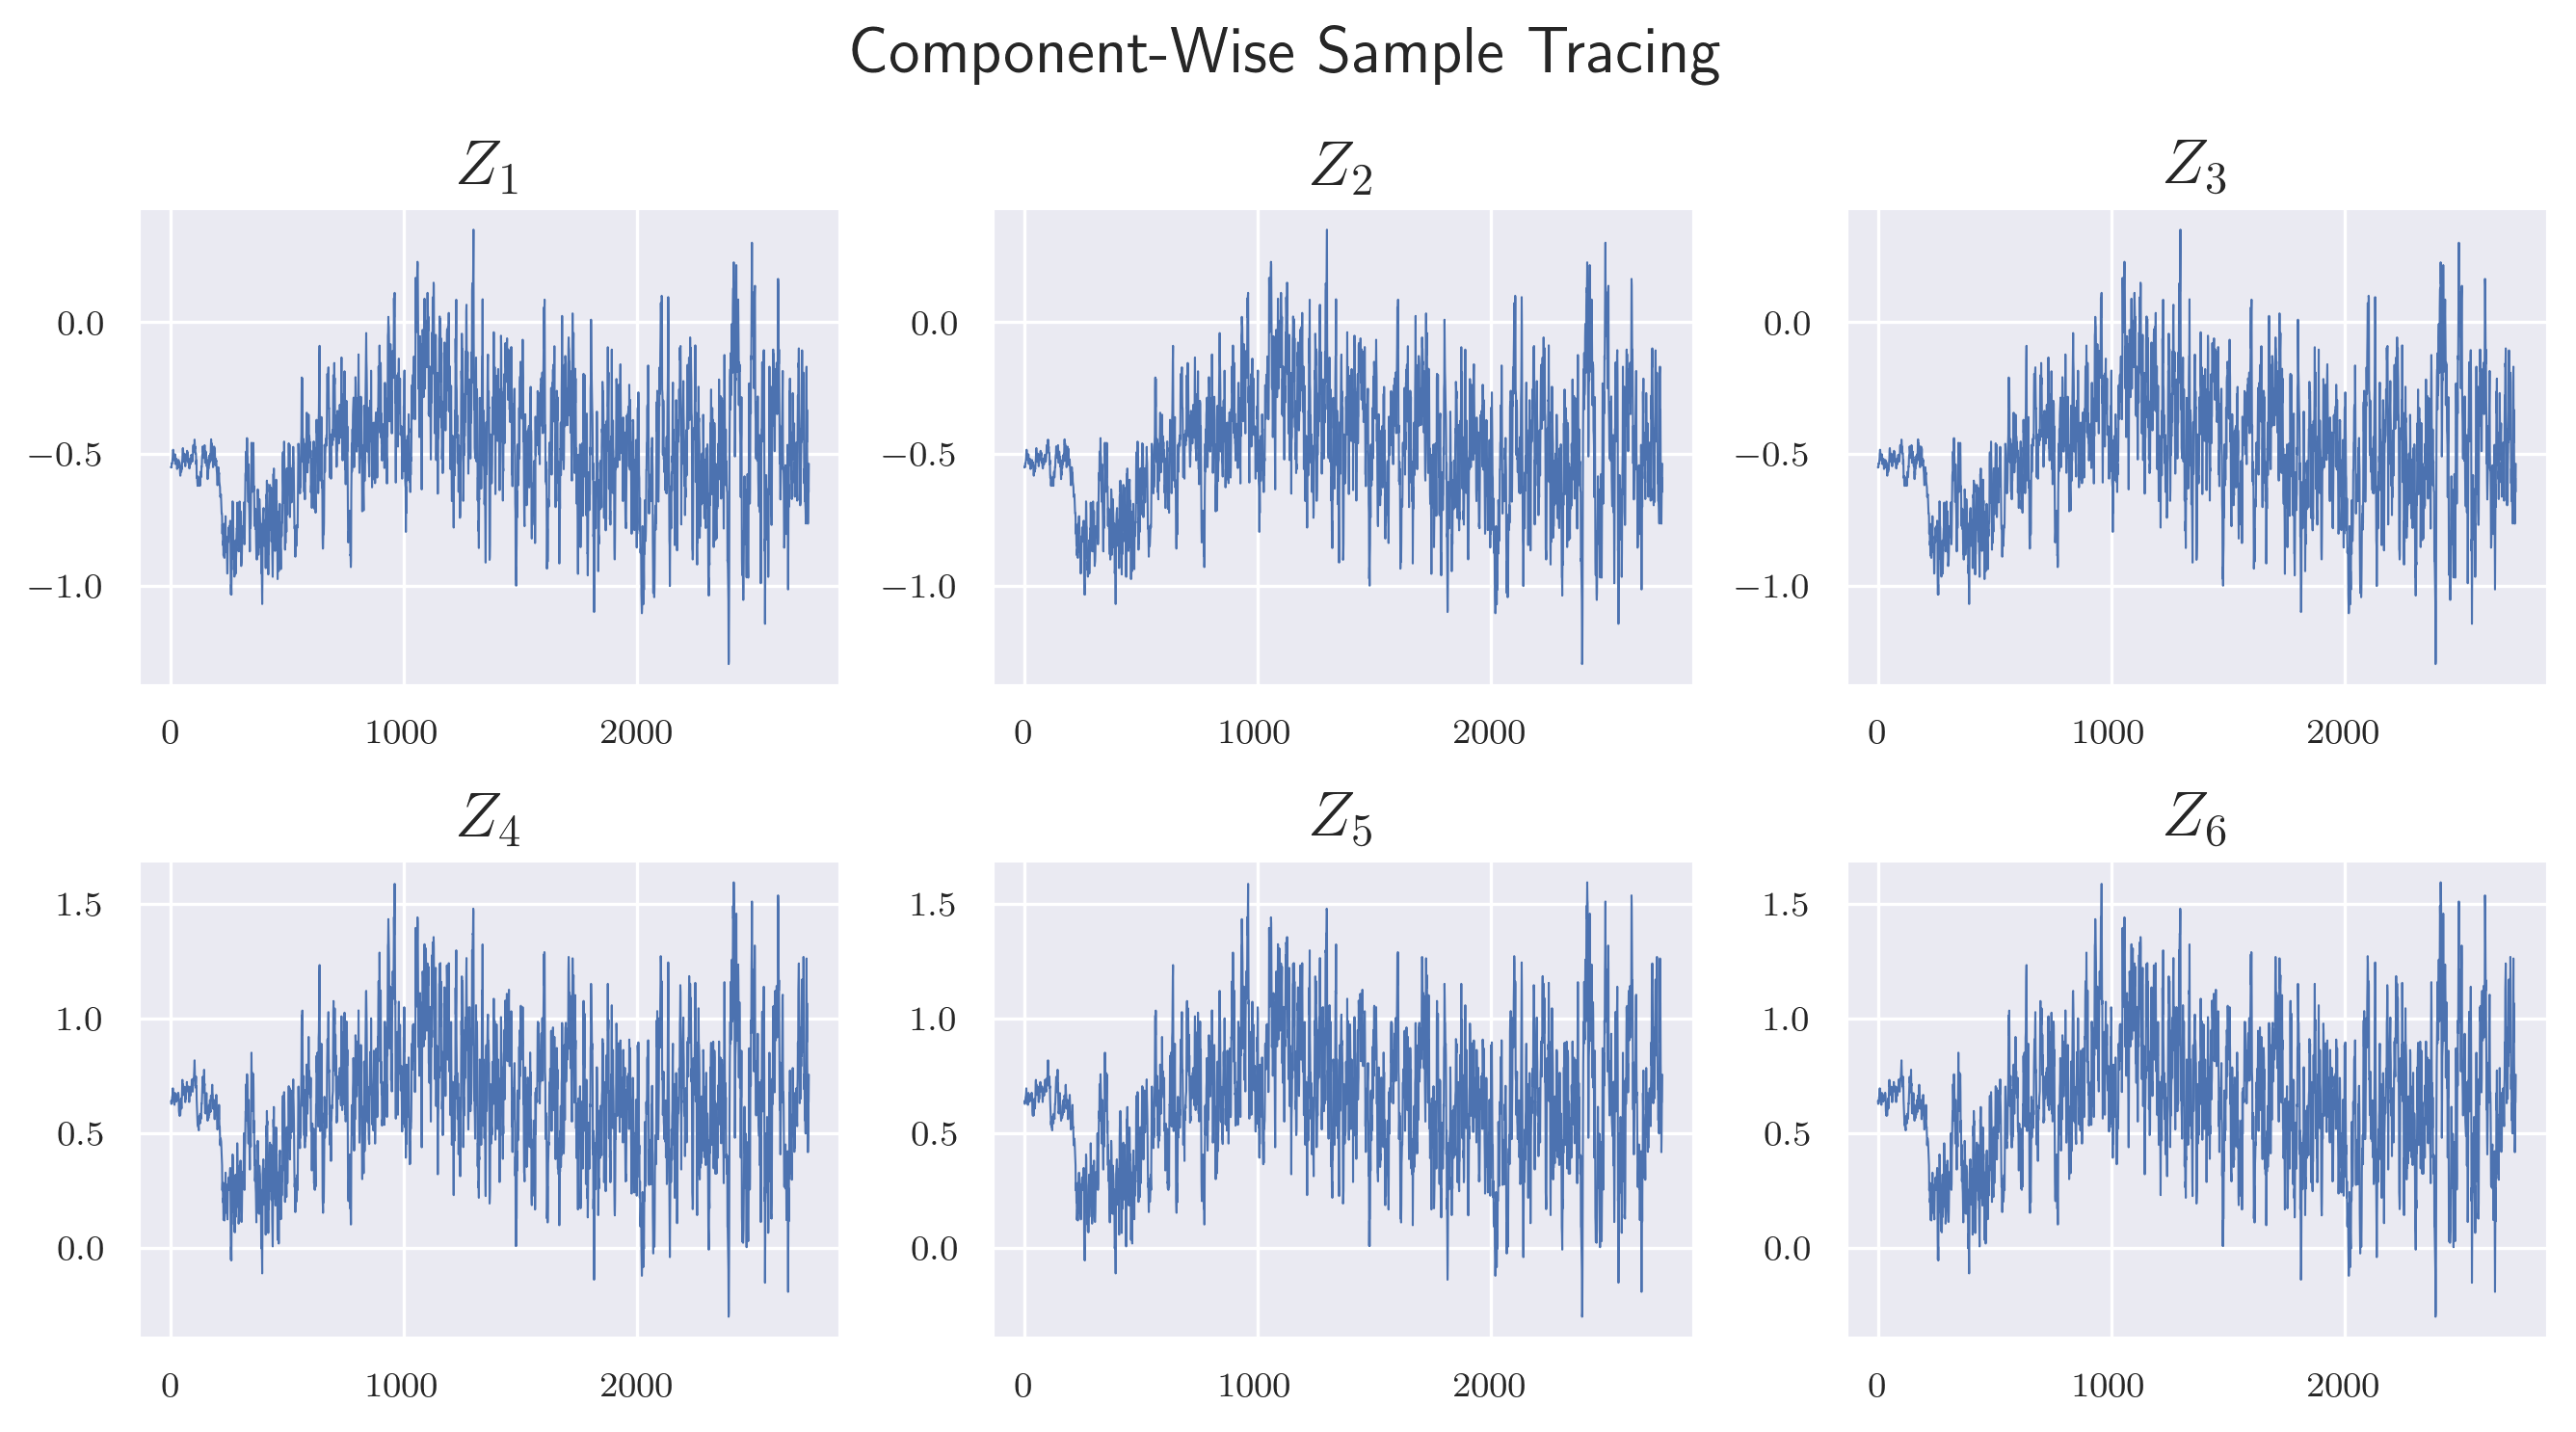

In [13]:
fig, ax = plt.subplots(2, 3, dpi = 300, figsize=(9, 5))
for i in range(2):
    for j in range(3):
        N = i*3 + j+1
        ax[i,j].plot(MCMCSamples[:,i], linewidth = .5, label=f"N = {N}")
        ax[i,j].set_title(fr"$Z_{N}$", fontsize=16)
plt.suptitle("Component-Wise Sample Tracing", fontsize=16)
plt.tight_layout()


Component-wise sample approximate marginal densities based on Kernel Density Estimation and pair-wise scatter plots are presented below for $Z_1$ through $Z_6$.

Text(0.5, 0.98, 'Adaptive Metropolis-Hastings')

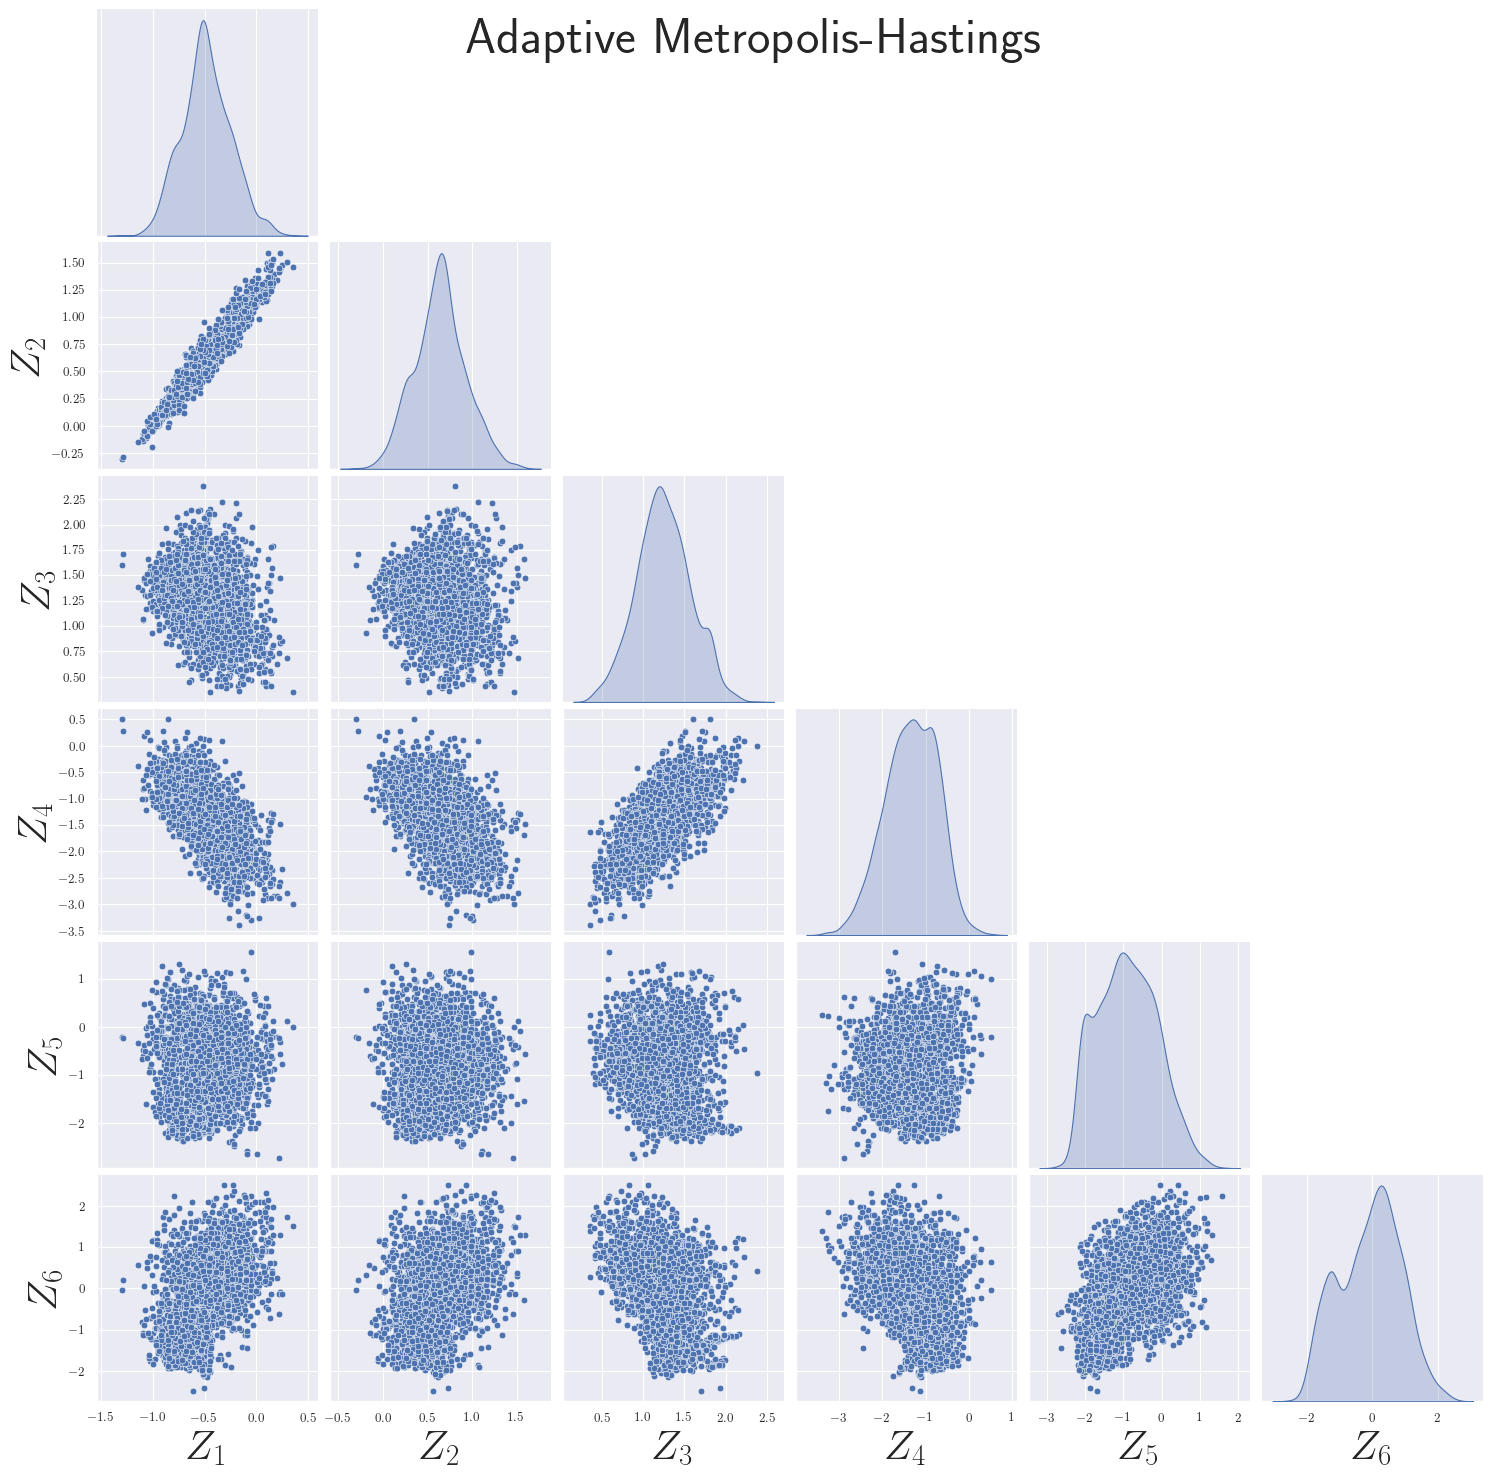

In [14]:
import pandas as pd
sns.set_context("paper", rc={"axes.labelsize":30})
df_mcmc = pd.DataFrame({
    r'$Z_1$' : MCMCSamples[:,0],
    r'$Z_2$' : MCMCSamples[:,1],
    r'$Z_3$' : MCMCSamples[:,2],
    r'$Z_4$' : MCMCSamples[:,3],
    r'$Z_5$' : MCMCSamples[:,4],
    r'$Z_6$' : MCMCSamples[:,5]
})
g = sns.pairplot(df_mcmc, corner=True, diag_kind='kde')
g.fig.suptitle("Adaptive Metropolis-Hastings", fontsize=36)


Component-wise sample trace plots of $Z_1$ through $Z_6$ are plotted below.

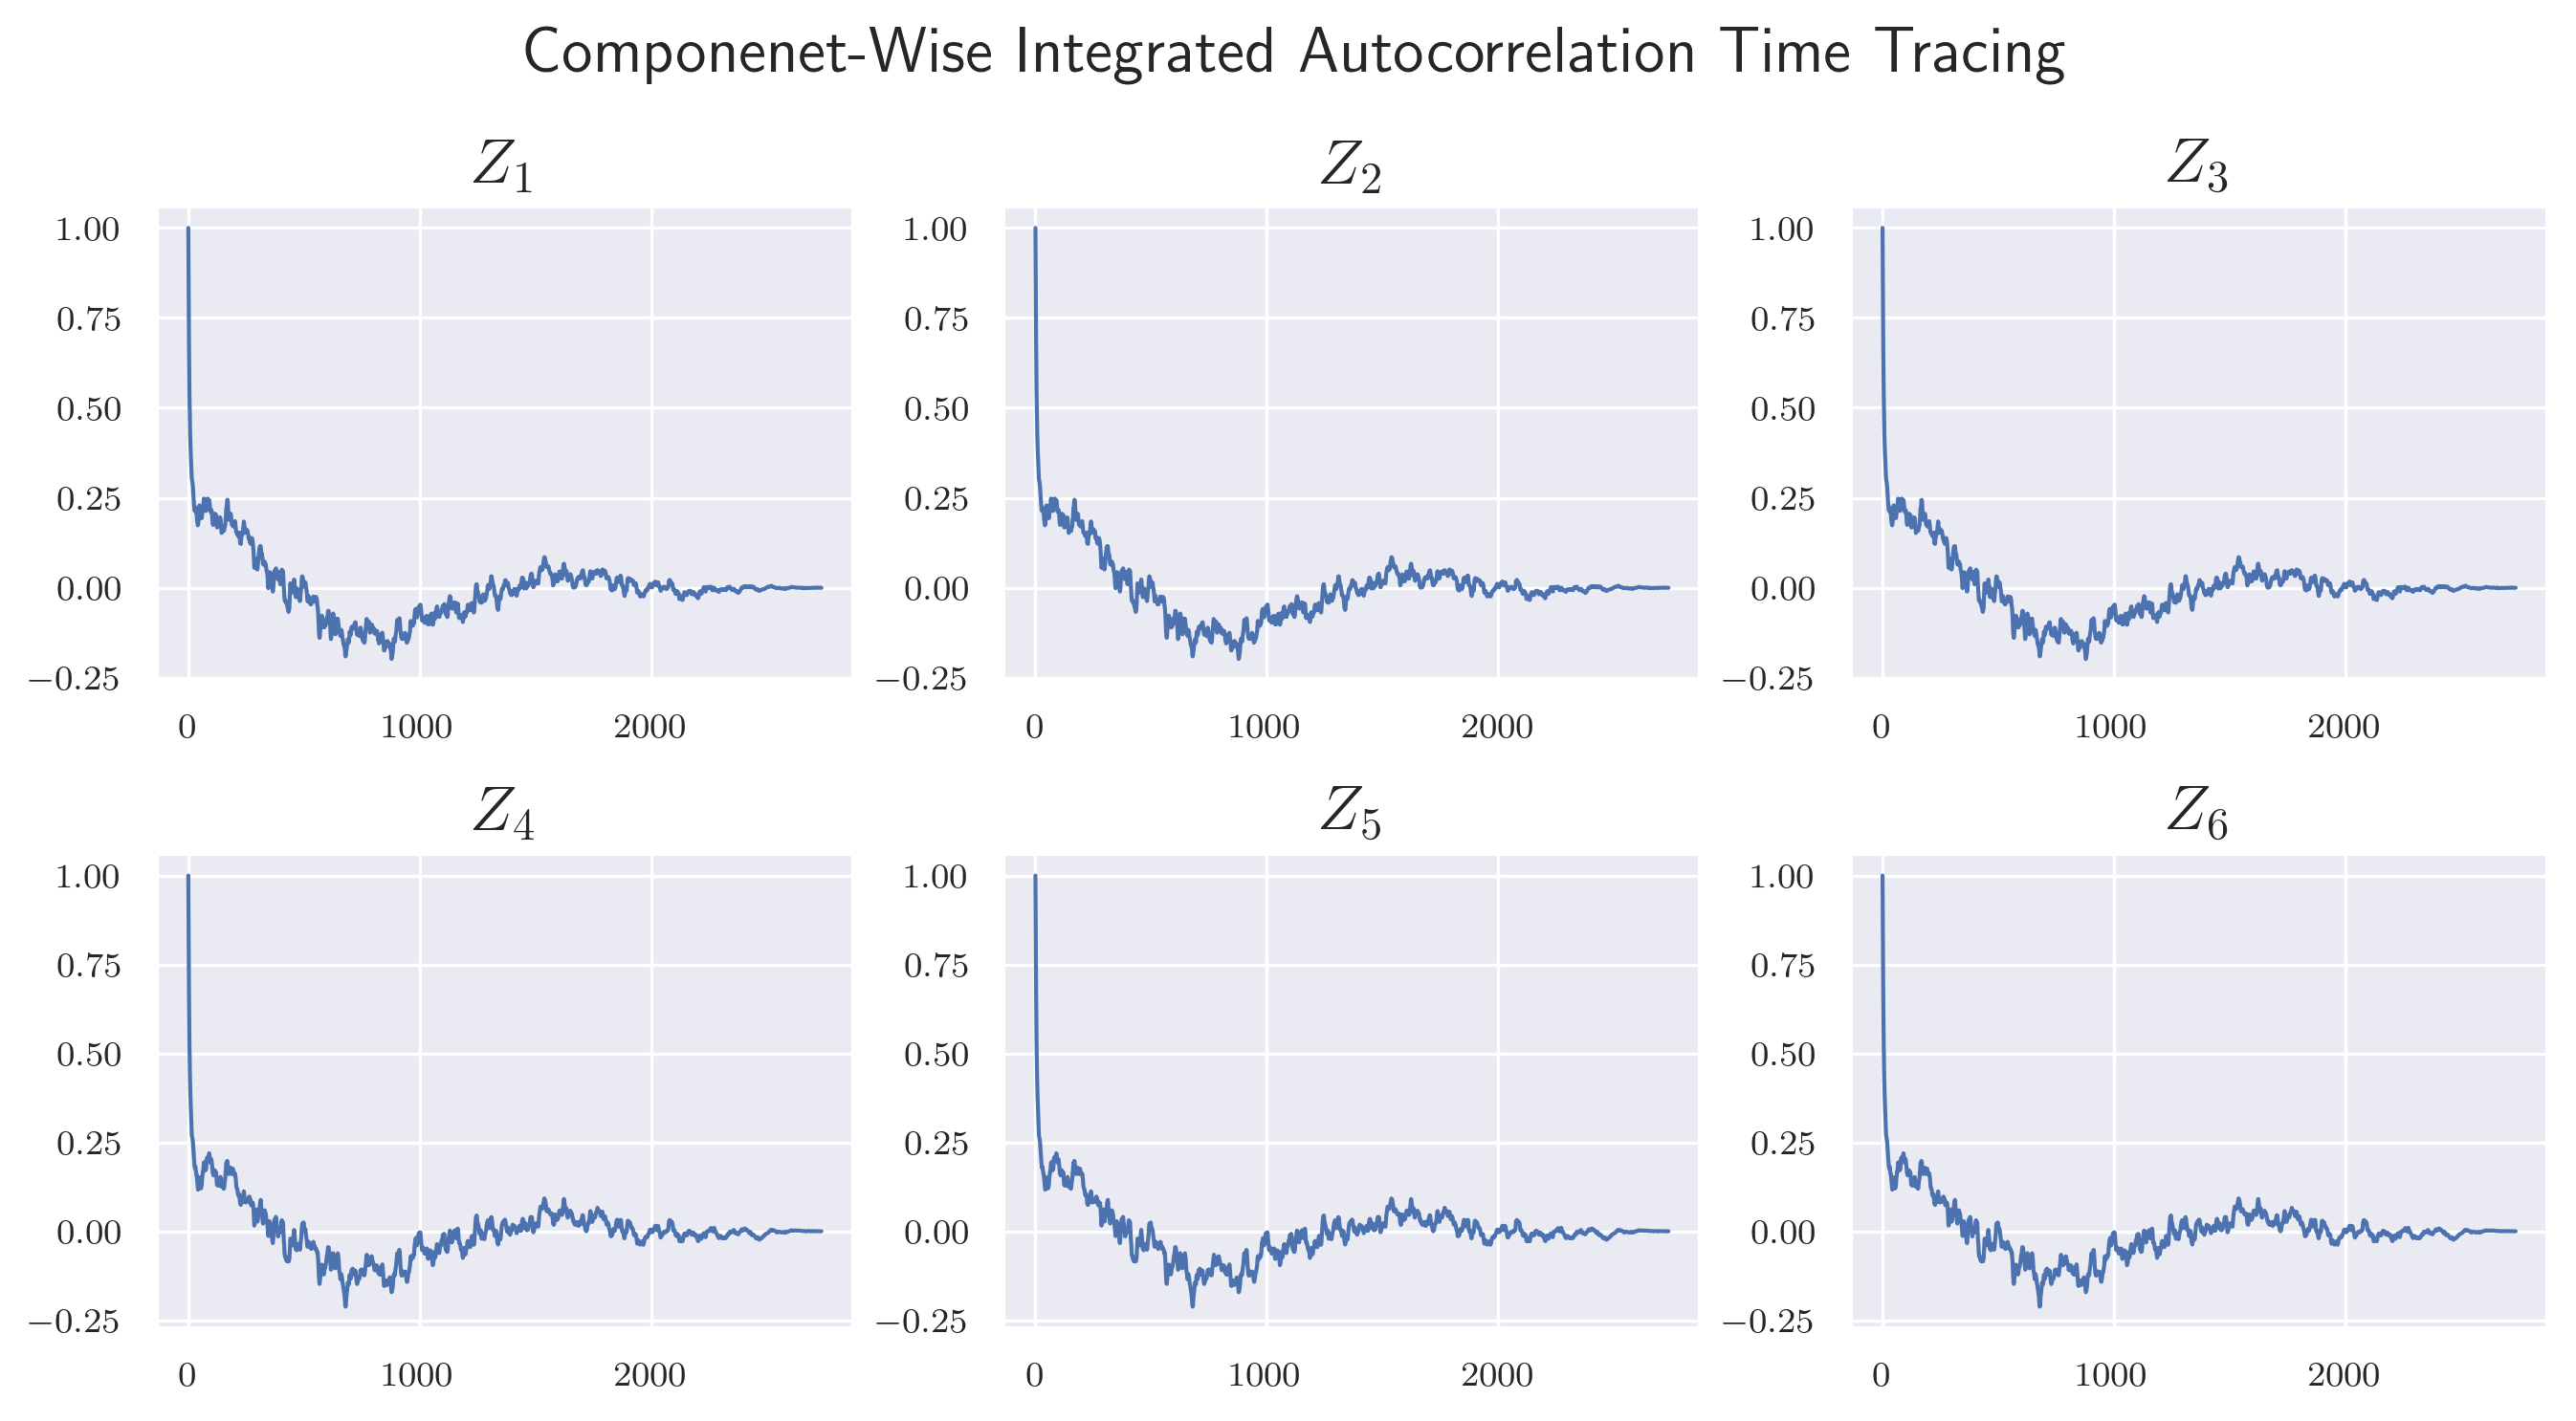

In [15]:
from emcee.autocorr import function_1d
# plot autocorrelation function for first N parameters
nz = 6
IAT = np.zeros((nz, MCMCSamples.shape[0]))
for i in range(nz):
    IAT[i,:] = function_1d(MCMCSamples[:,i])

fig, ax = plt.subplots(2, 3, dpi = 300, figsize=(9, 5))
for i in range(2):
    for j in range(3):
        N = i*3 + j+1
        ax[i,j].plot(IAT[i,:], linewidth = 1)
        ax[i,j].set_title(fr"$Z_{N}$", fontsize=16)
plt.suptitle("Componenet-Wise Integrated Autocorrelation Time Tracing", fontsize=16)
plt.tight_layout()

Below we plot the inferred log permeability and the inferred solution. For the solution, we see that we obtained a pretty accurate inference result compared to the true solution. For the log permeability, we see that while the general shape is well captured, the fine-scale variability does not match exactly. We suspect that this is because we might be using a rougher representation of the log permeability (15 K-L modes) than the true generation process. However, since the final goal is to infer the solution, the result is satisfying.

Component-wise integrated-autocorrelation-time-tracing plots of $Z_1$ through $Z_6$ are plotted below.

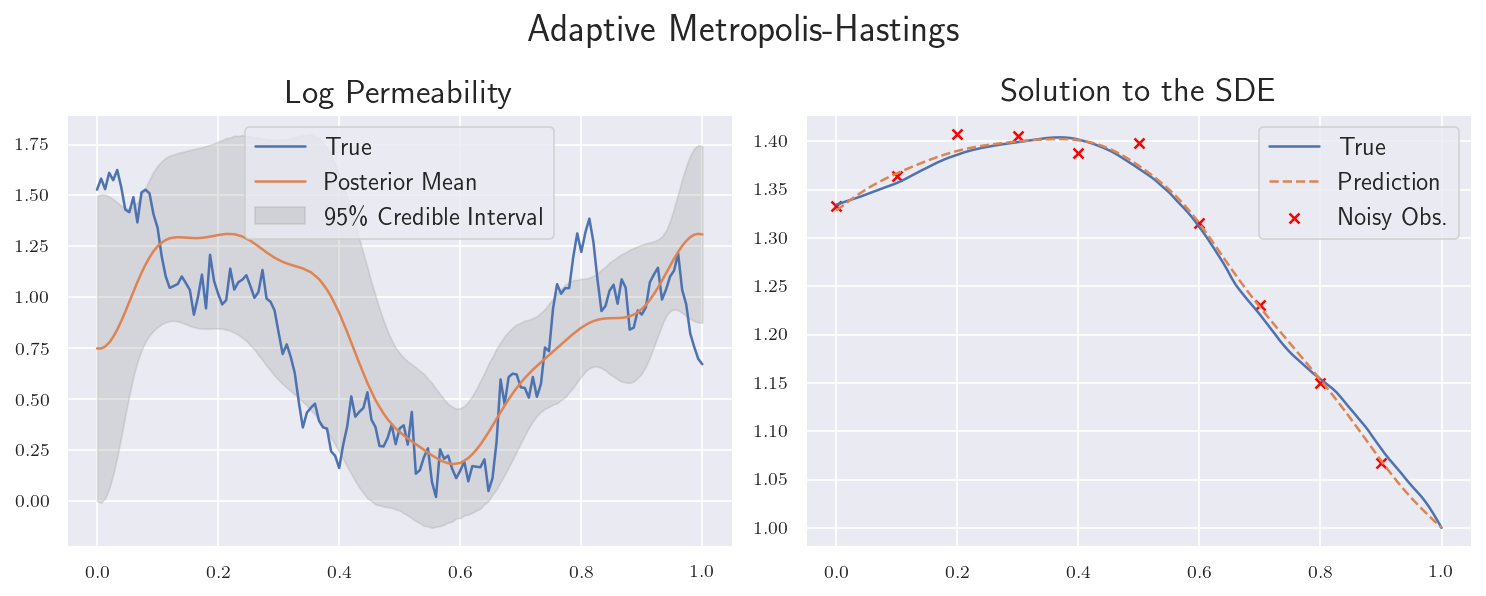

In [16]:
# post processing + plotting
mu = 1
kle = default_KLE(r)
y_samples = np.zeros((MCMCSamples.shape[0], xgrid.shape[0]))
for i in range(MCMCSamples.shape[0]):
    Zi = MCMCSamples[i,:]
    yi = mu + eval_KLE(kle,xgrid,Zi)
    y_samples[i,:] = yi
y_std = np.std(y_samples, axis=0)

# posterior mean
Z_mean = np.average(MCMCSamples, axis=0)
y_pred = mu + eval_KLE(kle, xgrid, Z_mean)
k_pred = np.exp(y_pred) 
u_true = sde_solve(ktrue)
u_pred = sde_solve(k_pred)

# plot
fig,ax = plt.subplots(1,2,dpi = 150,figsize=(10,4))
ax[0].plot(xgrid, np.log(ktrue), label='True ')
ax[0].plot(xgrid, y_pred, label='Posterior Mean')
ax[0].fill_between(xgrid, y_pred-1.96*y_std, y_pred+1.96*y_std, alpha=0.2, color="gray", label="95\% Credible Interval")
ax[0].set_title("Log Permeability", fontsize=16)
ax[0].legend(prop={'size': 12})

ax[1].plot(xgrid, u_true, label='True')
ax[1].plot(xgrid, u_pred, '--', label='Prediction')
ax[1].scatter(x_observed, u_observed, marker='x',label='Noisy Obs.', color='red')
ax[1].set_title('Solution to the SDE', fontsize=16)
ax[1].legend(prop={'size': 12})

plt.suptitle("Adaptive Metropolis-Hastings", fontsize=18)
plt.tight_layout()

The posterior covariance of the log permeability, estimated with the posterior samples, is compared with the prior covariance below. The covariances are plotted on the same scale.

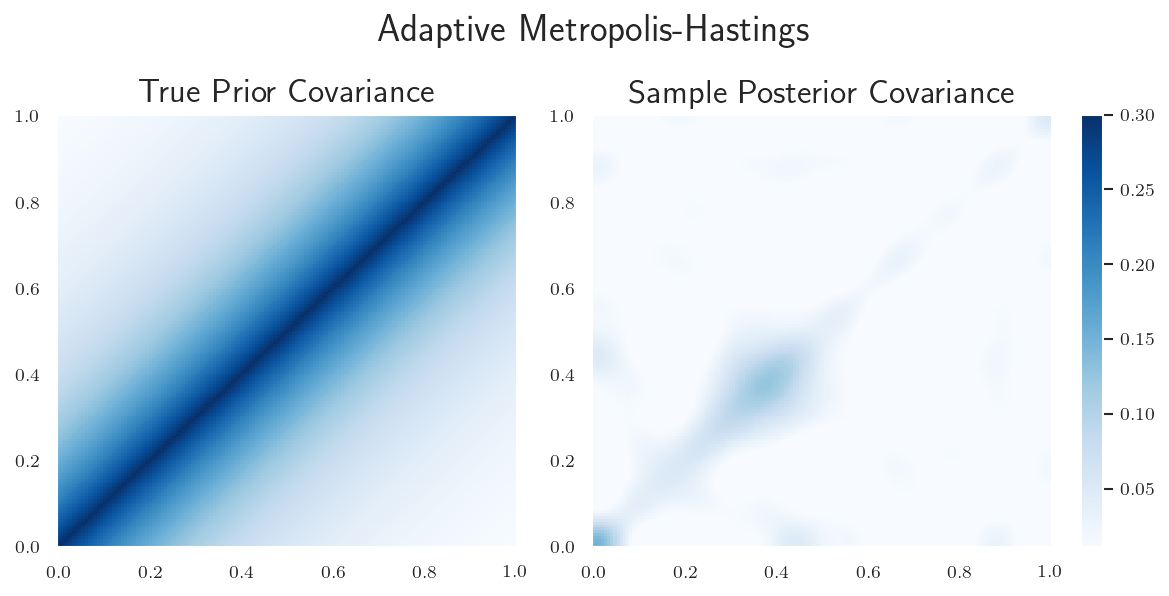

In [17]:
def cov(x, xprime=None, var=0.3, l=0.3, a=1.):
    """ 
    A Particular GP Covariance

    x: vector of input points, (n,)
    xprime : another vector of input points
    """
    if xprime is None:
        grid = np.meshgrid(x,x, indexing='ij')
    else:
        grid = np.meshgrid(x, xprime, indexing='ij')
        
    x1 = grid[0]
    x2 = grid[1]
    return var*np.exp(-1/a * np.power(np.abs(x1-x2) / l, a))

# covariance
post_cov = np.cov(y_samples, rowvar=False)
prior_cov = cov(xgrid)

# plot
fig, ax = plt.subplots(1,2, figsize = (8,4), dpi=150, 
                       gridspec_kw={'width_ratios': [4, 5]})

# posterior covariance
plt2 = ax[0].pcolormesh(xgrid, xgrid, prior_cov, cmap="Blues")
cbar = fig.colorbar(plt2)
ax[0].set_title(fr"True Prior Covariance", fontsize=16)

# covariacne
plt3 = ax[1].pcolormesh(xgrid, xgrid, post_cov, cmap="Blues")
cbar2 = fig.colorbar(plt3)
cbar2.mappable.set_clim(*cbar.mappable.get_clim()) # set on the same scale
cbar.remove() # remove the first color bar
ax[1].set_title("Sample Posterior Covariance", fontsize=16)

plt.suptitle("Adaptive Metropolis-Hastings", fontsize=18)
plt.tight_layout()

<!-- ## 1.(b) -->

The form of the likelihood model in this part remains the same while the prior becomes 
$$
p(Z,\sigma_{\epsilon}) \propto p(Z)\,p_{hp}(\sigma_{\epsilon})
$$
where "$hp$" stands for hyperprior. Note that here we are working with $\sigma_{\epsilon}$ instead of $\sigma_{\epsilon}^2$. The rest remains the same.

We will construct an MCMC sampler that efficiently explores the joint posterior distribution of $k(x)$ and $\sigma_\epsilon^2$.

In [347]:
def AdaMH2(r, N0, C0, N, eps=1e-4):
    """ Sample from target density pi using Metropolis-Hasting algorithm and isotropic Gaussian proposal"""

    # store samples; initialization
    init_sampler = mvn(np.zeros((r+1,)), C0)
    init = init_sampler.rvs(1)
    burnin_samples = init.reshape(1,-1)

    # initial phase
    for _ in range(1,N0):
        theta_prev = burnin_samples[-1,:]
        theta_curr = theta_prev + .5*init_sampler.rvs(1)

        Z_prev = theta_prev[:-1]
        Z_curr = theta_curr[:-1]
        std_prev = theta_prev[-1]
        std_curr = theta_curr[-1]
        alpha = accept_ratio(Z_prev, Z_curr, std_prev, std_curr)
        if np.random.random() < alpha:
            burnin_samples = np.vstack((burnin_samples, theta_curr.reshape(1,-1)))
        
    # adaptive phase
    I = np.eye(r+1)
    samples = burnin_samples[-2:-1,:]
    Sn = np.zeros((r+1,r+1))
    Cn = 2.4**2/(r+1) * Sn + eps*I
    Tn_bar = samples
    for n in range(N):
        theta_prev = samples[-1,:]
        theta_curr = theta_prev + .5*mvn.rvs(np.zeros((r+1,)),Cn,1)

        Z_prev = theta_prev[:-1]
        Z_curr = theta_curr[:-1]
        std_prev = theta_prev[-1]
        std_curr = theta_curr[-1]
        alpha = accept_ratio(Z_prev, Z_curr, std_prev, std_curr)
        if np.random.random() < alpha:
            # store sample
            samples = np.vstack((samples, theta_curr.reshape(1,-1)))

            # update covariance
            ns = samples.shape[0]
            Sn = (ns-2)/(ns-1) * Sn + 1/ns*(theta_curr-Tn_bar).reshape(-1,1) @ (theta_curr-Tn_bar).reshape(1,-1)
            Sn = np.cov(samples, rowvar=False)
            Cn = 2.4**2/(r+1) * Sn + eps*I

            # update mean
            Tn_bar = (ns-1)/ns * Tn_bar + 1/ns * theta_curr

    return samples 

Here we run the adaptive Metropolis-Hastings algorithm with a stochastic dimension of 15, an initial phase of 2000 steps ($n_0 = 2000$), and 10000 steps in total.

In [348]:
# Run Adaptive M-H on the Z-sigma joint distribution
r = 15
N0 = 2000
s = 1.
C0 = s*np.eye(r+1)
N = 8000
MCMCSamples2 = AdaMH2(r,N0,C0,N)

Component-wise sample trace plots of $Z_1$ through $Z_5$ and $\sigma_{\epsilon}$ are plotted below.

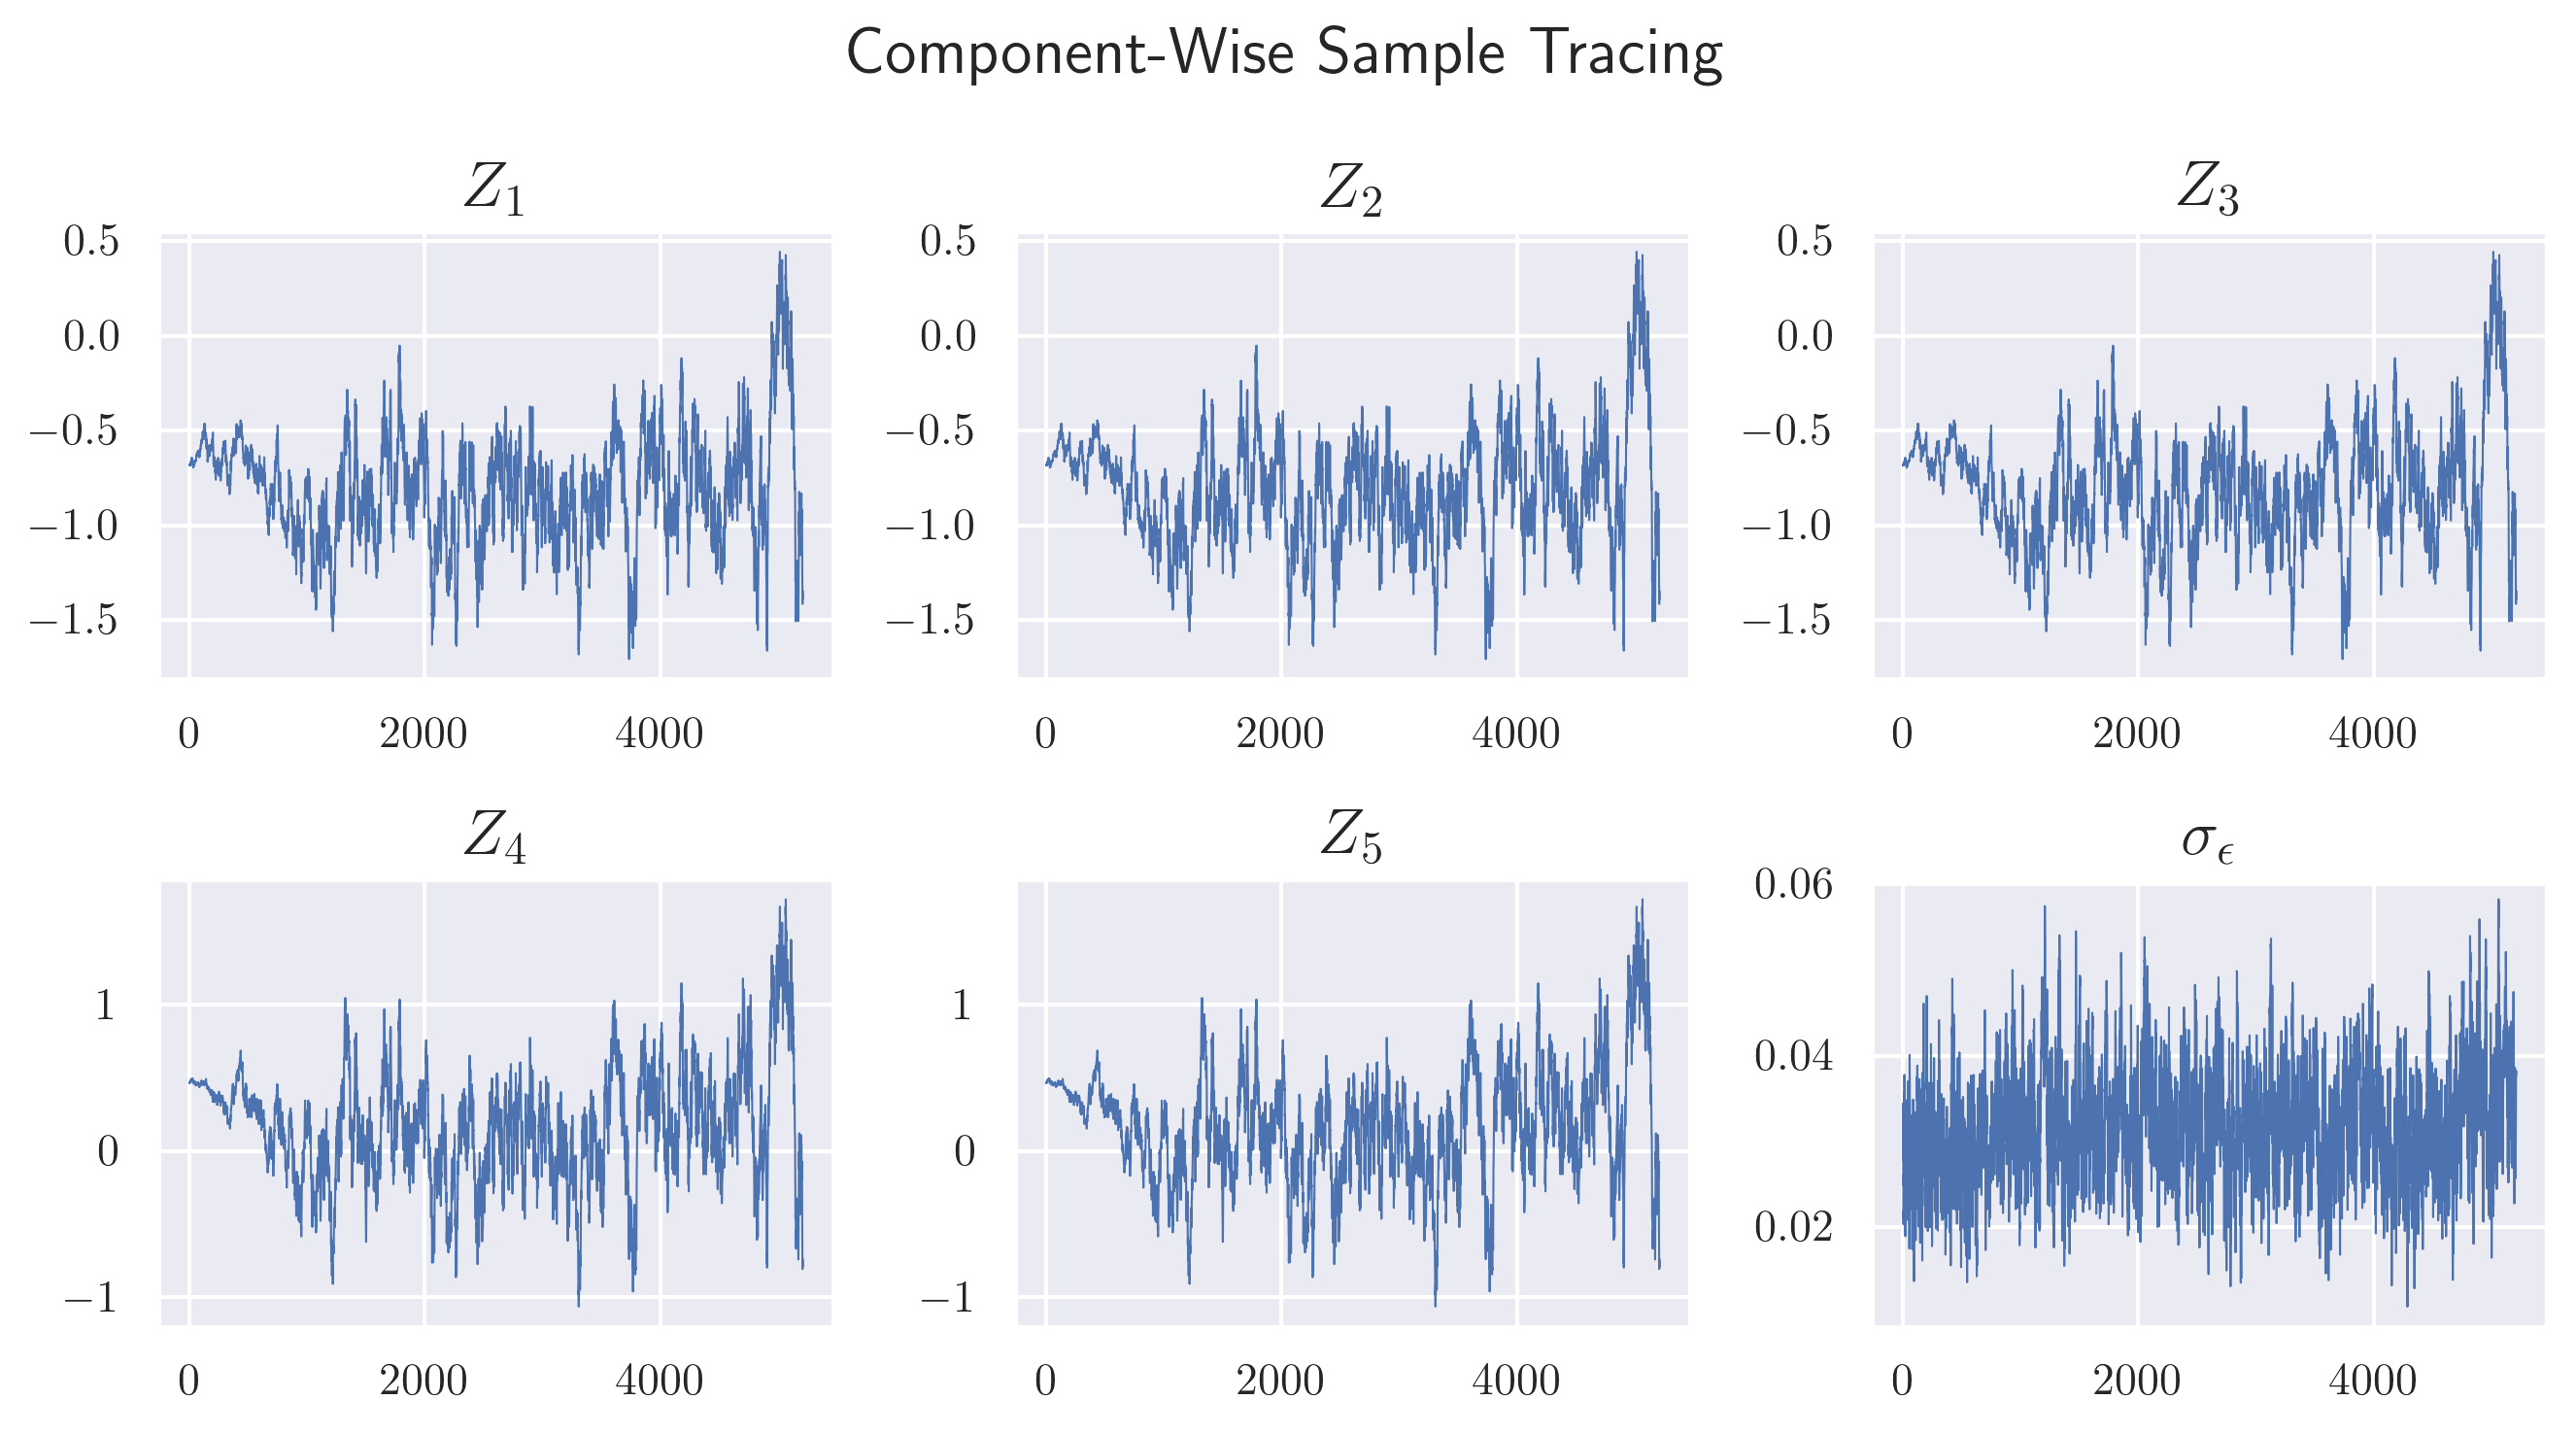

In [349]:
sig_samples = MCMCSamples2[:,-1]
fig, ax = plt.subplots(2, 3, dpi = 300, figsize=(9, 5))
for i in range(2):
    for j in range(3):
        N = i*3 + j+1
        if N != 6:
            ax[i,j].plot(MCMCSamples2[:,i], linewidth = .5)
            ax[i,j].set_title(fr"$Z_{N}$", fontsize=16)
        else:
            ax[i,j].plot(sig_samples, linewidth = .5)
            ax[i,j].set_title(r"$\sigma_{\epsilon}$", fontsize=16)
plt.suptitle("Component-Wise Sample Tracing", fontsize=16)
plt.tight_layout()


Component-wise integrated-autocorrelation-time-tracing plots of $Z_1$ through $Z_5$ and $\sigma_{\epsilon}$ are plotted below.

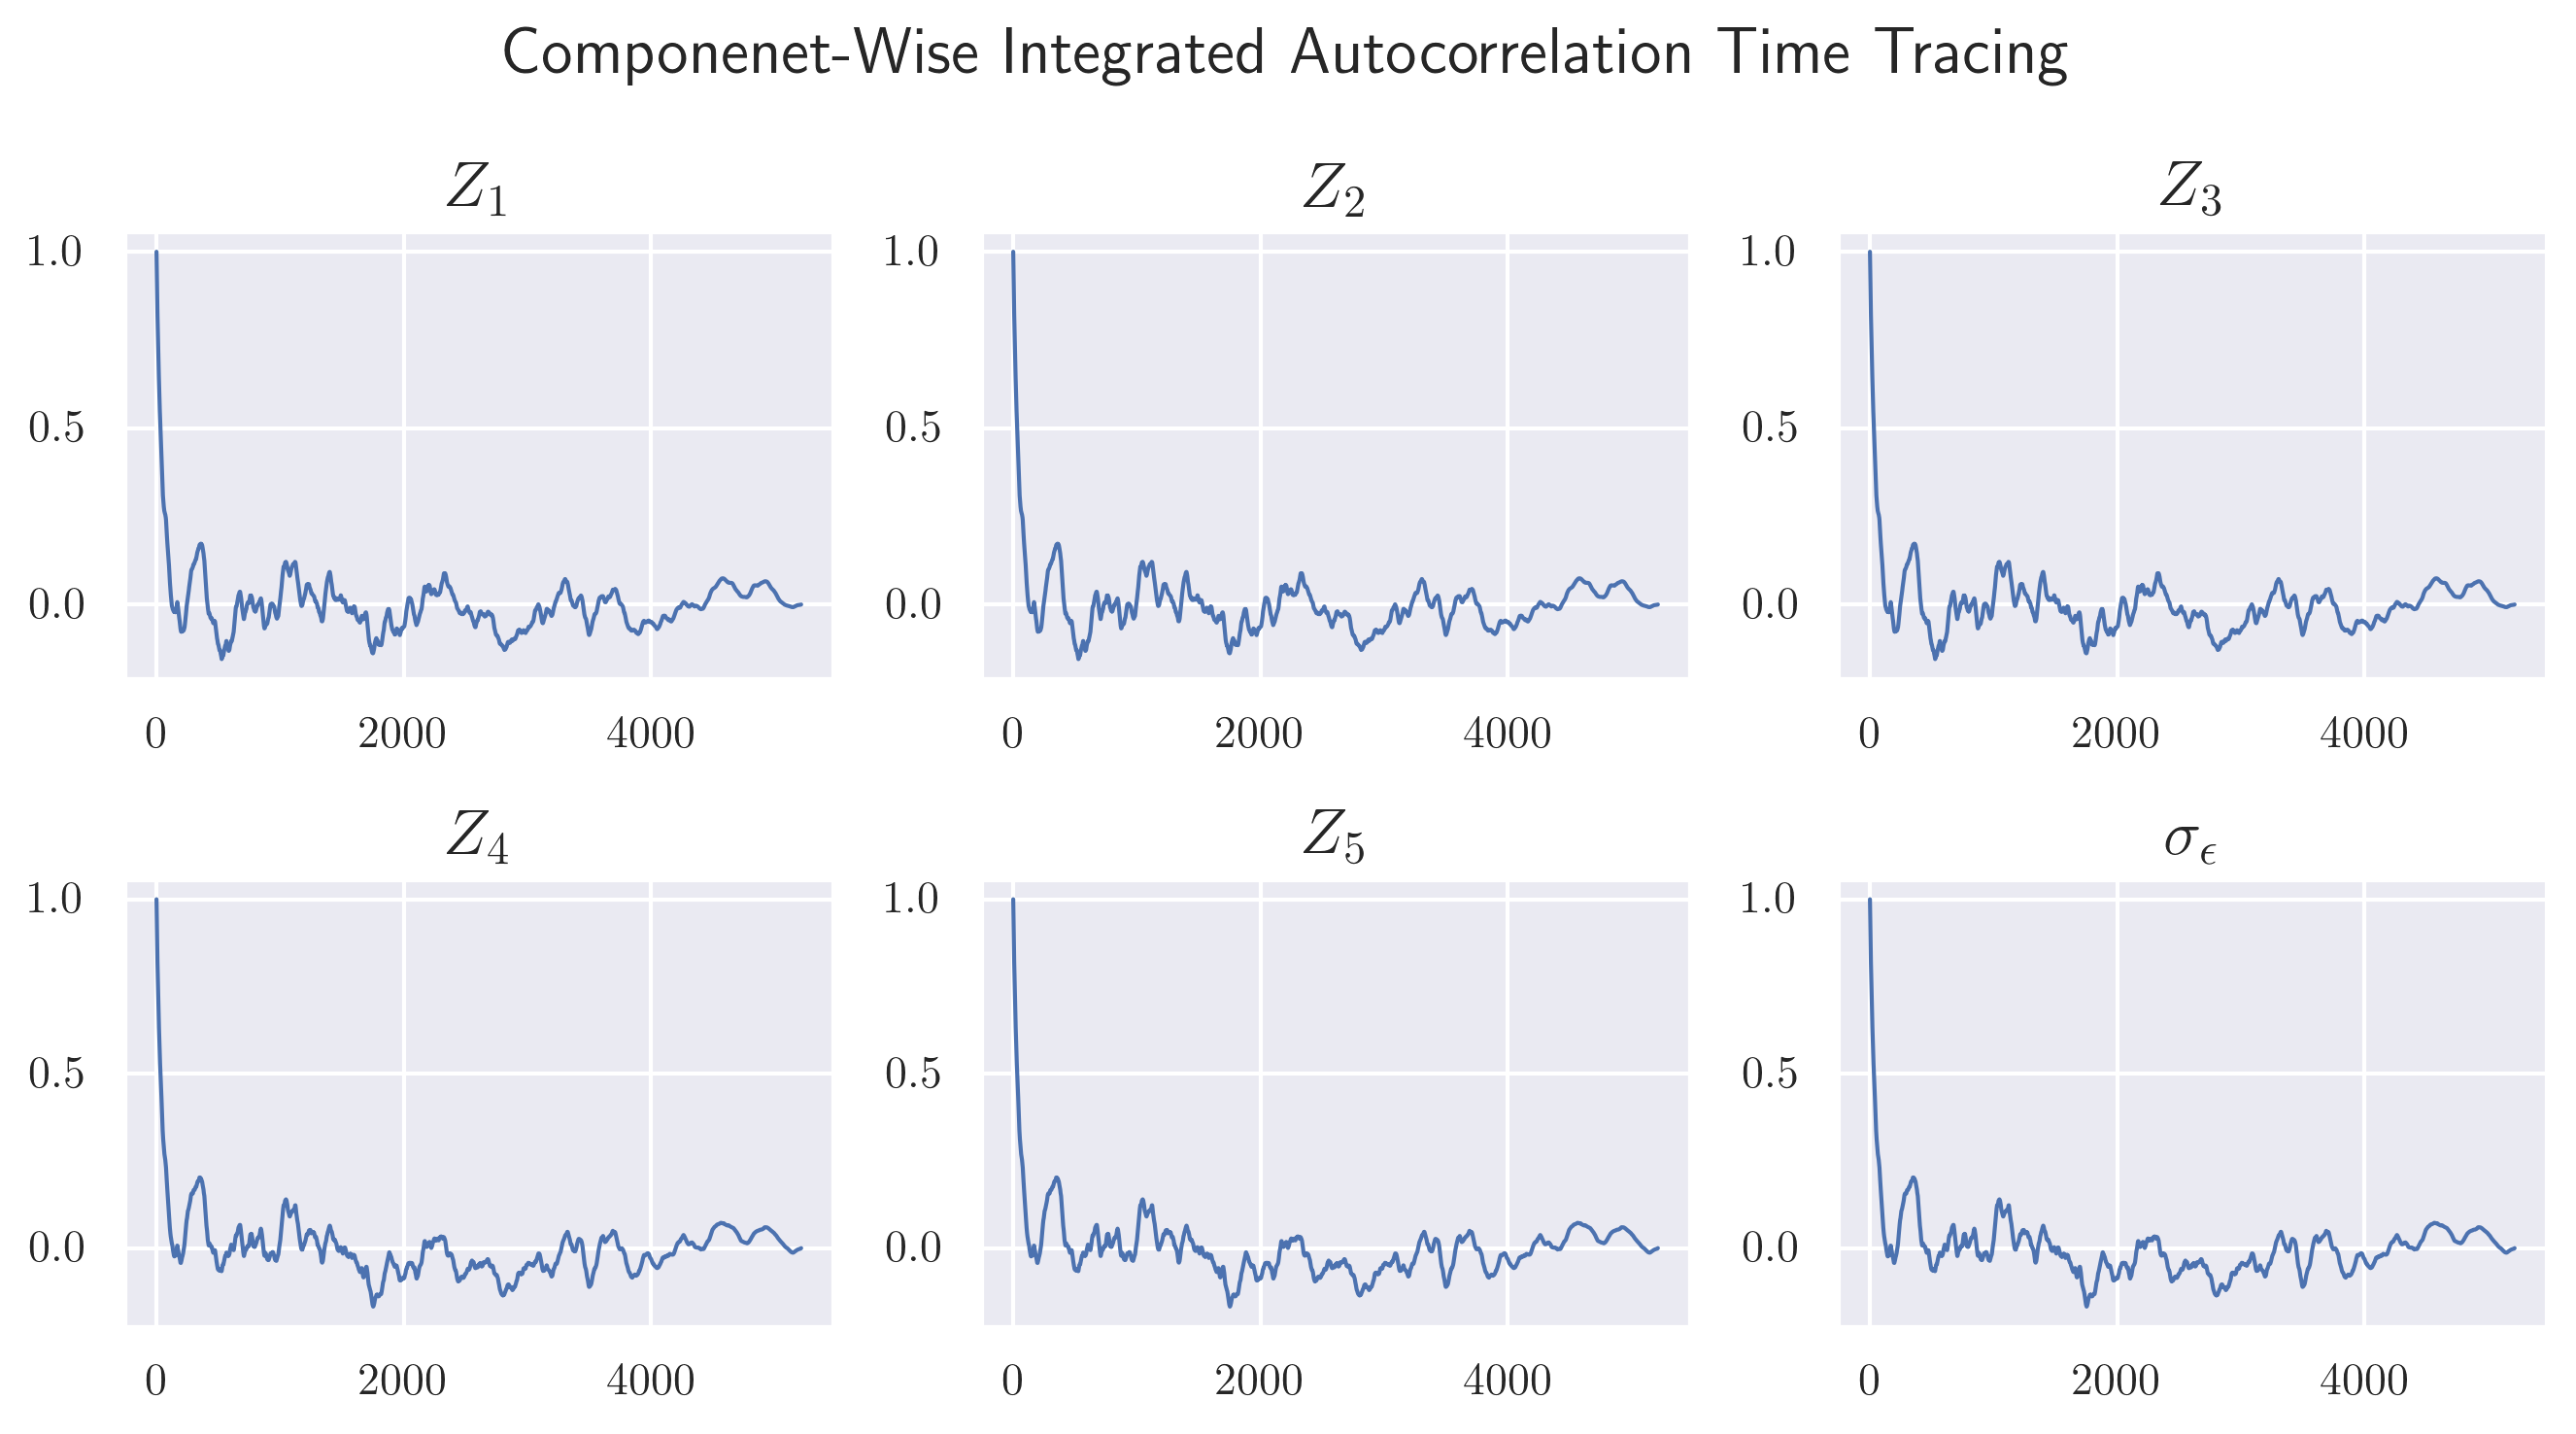

In [350]:
import emcee
# plot autocorrelation function for first N parameters
nz = 5
IAT = np.zeros((nz+1, MCMCSamples2.shape[0]))
for i in range(N):
    IAT[i,:] = emcee.autocorr.function_1d(MCMCSamples2[:,i])
IAT[-1,:] = emcee.autocorr.function_1d(sig_samples)

fig, ax = plt.subplots(2, 3, dpi = 300, figsize=(9, 5))
for i in range(2):
    for j in range(3):
        N = i*3 + j+1
        ax[i,j].plot(IAT[i,:], linewidth = 1)
        if N != 6:
            ax[i,j].set_title(fr"$Z_{N}$", fontsize=16)
        else:
            ax[i,j].set_title(r"$\sigma_{\epsilon}$", fontsize=16)
plt.suptitle("Componenet-Wise Integrated Autocorrelation Time Tracing", fontsize=16)
plt.tight_layout()

Component-wise sample approximate marginal densities based on Kernel Density Estimation and pair-wise scatter plots are presented below for $Z_1$ through $Z_5$ and $\sigma_{\epsilon}$.

Text(0.5, 0.98, 'Adaptive Metropolis-Hastings with $\\sigma_{\\epsilon}$')

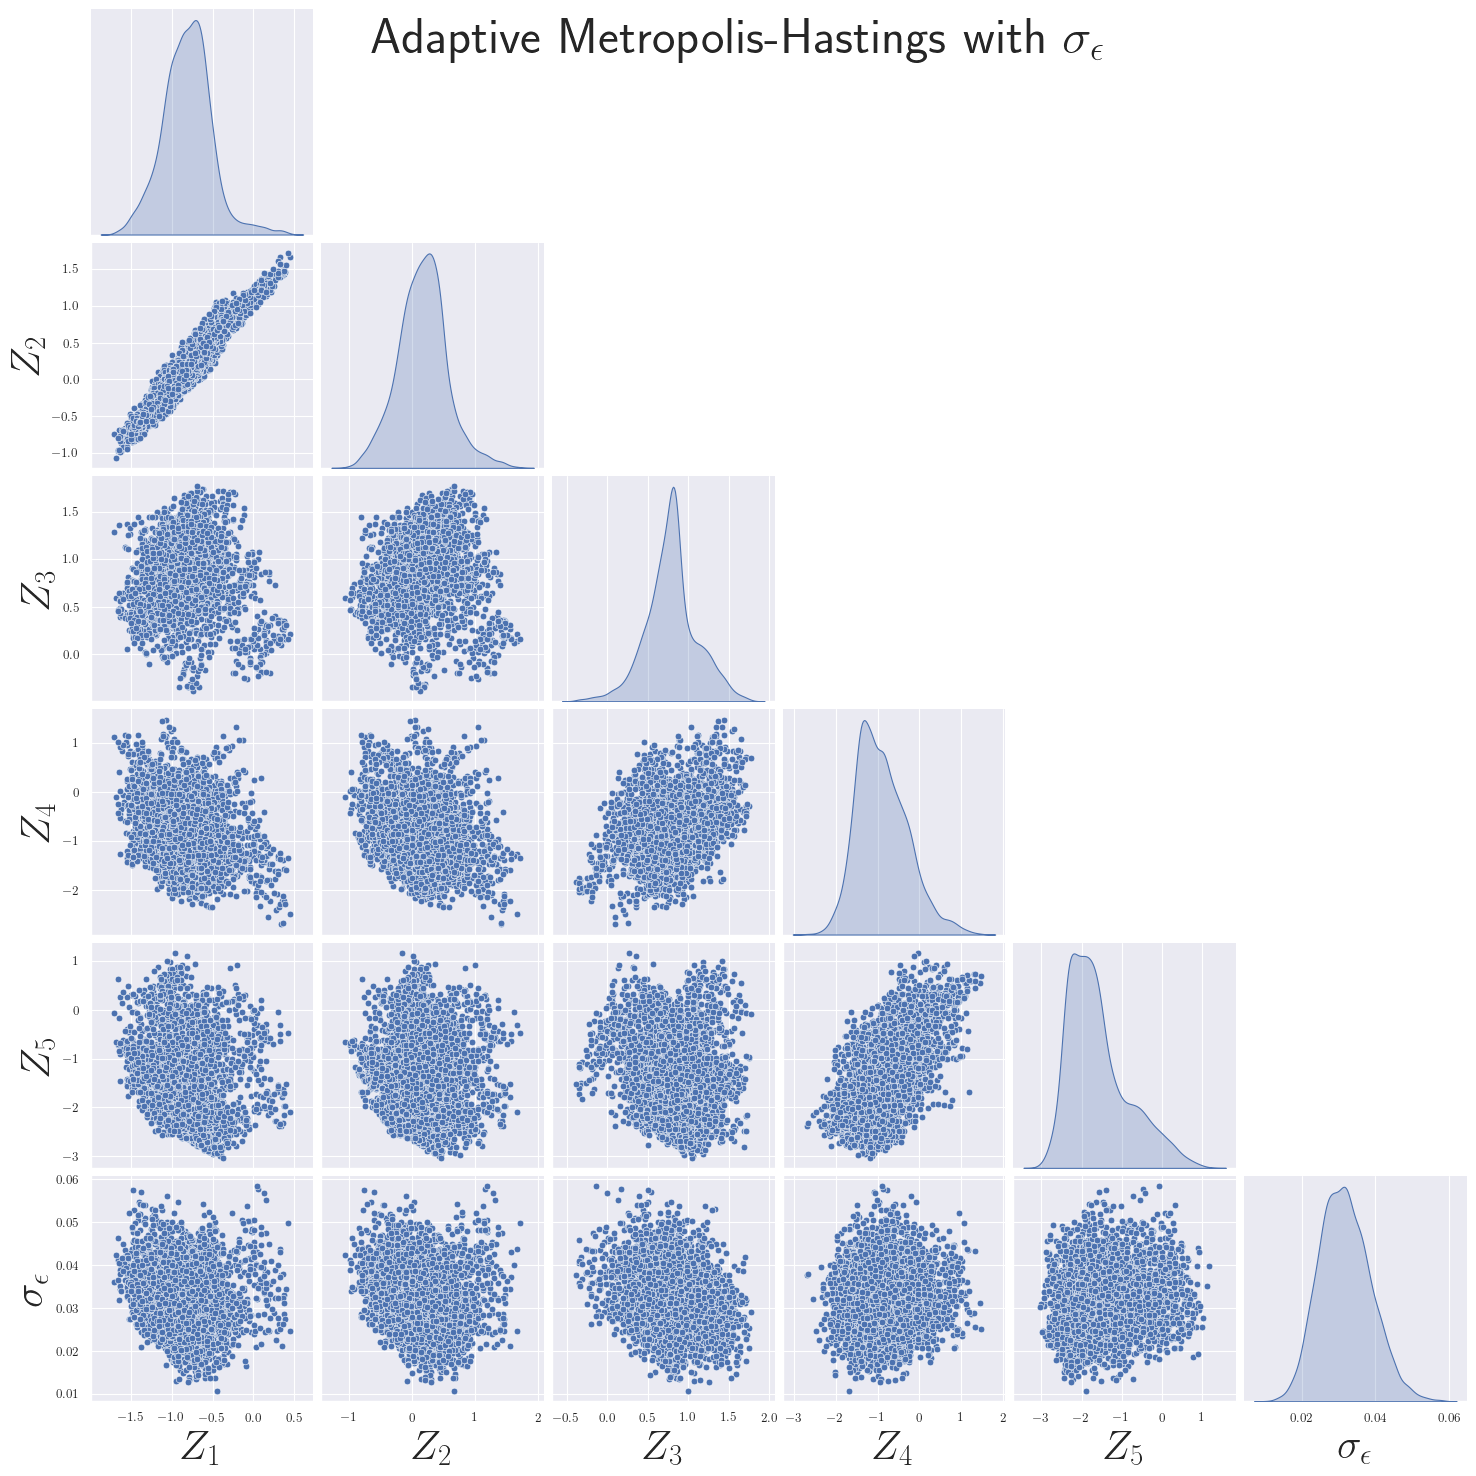

In [380]:
import pandas as pd
sns.set_context("paper", rc={"axes.labelsize":30})
df_mcmc2 = pd.DataFrame({
    r'$Z_1$' : MCMCSamples2[:,0],
    r'$Z_2$' : MCMCSamples2[:,1],
    r'$Z_3$' : MCMCSamples2[:,2],
    r'$Z_4$' : MCMCSamples2[:,3],
    r'$Z_5$' : MCMCSamples2[:,4],
    r'$\sigma_{\epsilon}$' : MCMCSamples2[:,-1]
})
g = sns.pairplot(df_mcmc2, corner=True, diag_kind='kde')
g.fig.suptitle(r"Adaptive Metropolis-Hastings with $\sigma_{\epsilon}$", fontsize=36)

Below we plot the inferred log permeability and the inferred solution. We see that we obtained a pretty accurate inference result.

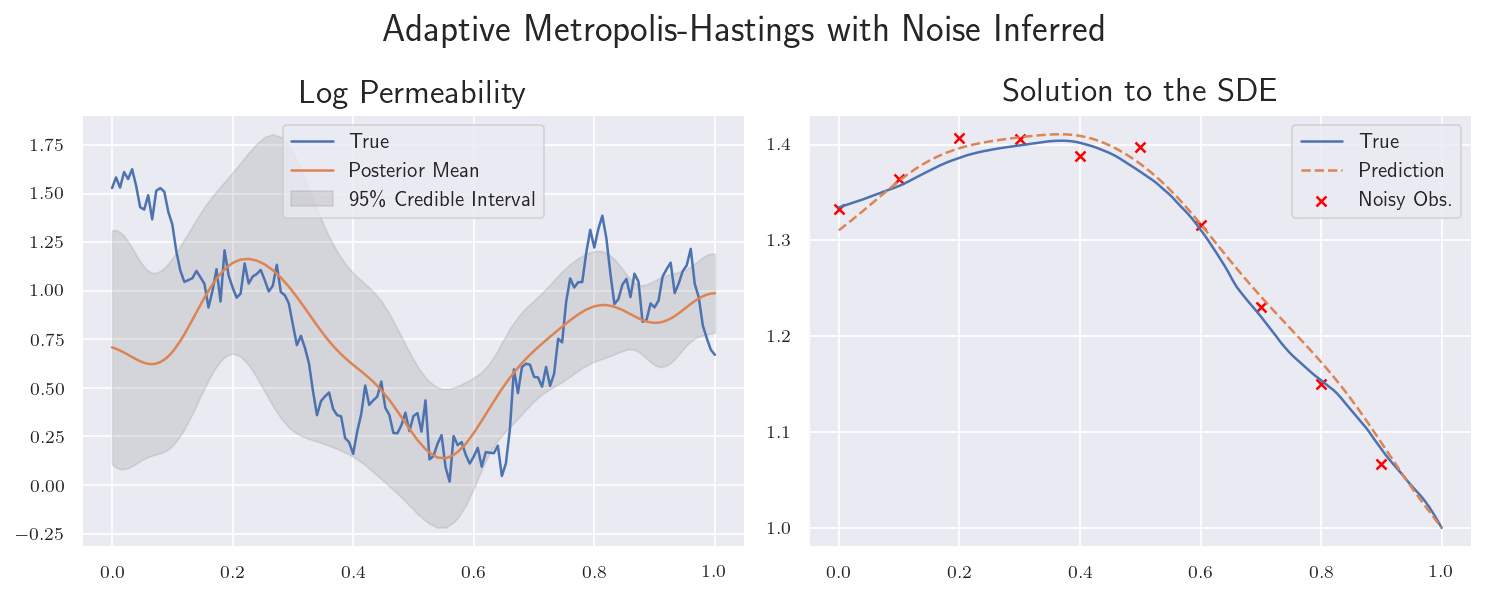

In [463]:
# post processing + plotting
mu = 1
kle = default_KLE(r)
y_samples2 = np.zeros((MCMCSamples2.shape[0]-1, xgrid.shape[0]))
for i in range(MCMCSamples2.shape[0]-1):
    Zi = MCMCSamples2[i,:-1]
    yi = mu + eval_KLE(kle,xgrid,Zi)
    y_samples2[i,:] = yi
y_std = np.std(y_samples2, axis=0)

# posterior mean
Z_mean = np.average(MCMCSamples2[:,:-1], axis=0)
y_pred = mu + eval_KLE(kle, xgrid, Z_mean)
k_pred = np.exp(y_pred) 
u_true = sde_solve(ktrue)
u_pred = sde_solve(k_pred)

# plot
fig,ax = plt.subplots(1,2,dpi = 150,figsize=(10,4))
ax[0].plot(xgrid, np.log(ktrue), label='True ')
ax[0].plot(xgrid, y_pred, label='Posterior Mean')
ax[0].fill_between(xgrid, y_pred-1.96*y_std, y_pred+1.96*y_std, alpha=0.2, color="gray", label="95\% Credible Interval")
ax[0].set_title("Log Permeability", fontsize=16)
ax[0].legend(prop={'size': 10})

ax[1].plot(xgrid, u_true, label='True')
ax[1].plot(xgrid, u_pred, '--', label='Prediction')
ax[1].scatter(x_observed, u_observed, marker='x',label='Noisy Obs.', color='red')
ax[1].set_title('Solution to the SDE', fontsize=16)
ax[1].legend(prop={'size': 10})

plt.suptitle("Adaptive Metropolis-Hastings with Noise Inferred", fontsize=18)
plt.tight_layout()

The posterior covariance of the log permeability, estimated with the posterior samples, is compared with the prior covariance below. The covariances are plotted on the same scale.

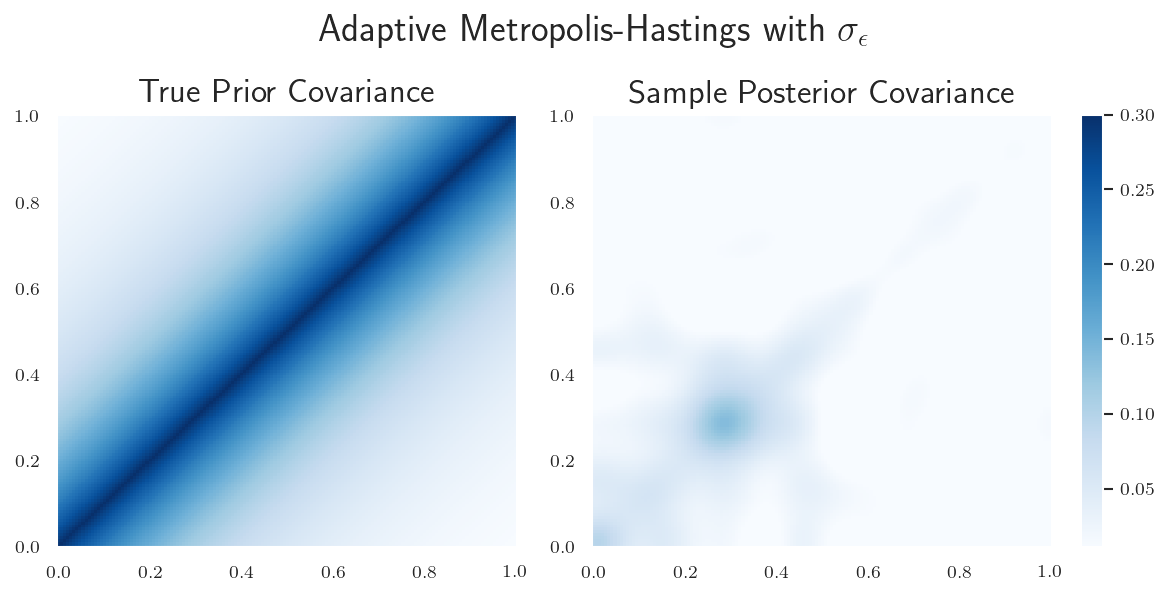

In [404]:
post_cov = np.cov(y_samples2, rowvar=False)

# true prior covariance
prior_cov = cov(xgrid)

# plot
fig, ax = plt.subplots(1,2, figsize = (8,4), dpi=150, 
                       gridspec_kw={'width_ratios': [4, 5]})

# posterior covariance
plt2 = ax[0].pcolormesh(xgrid, xgrid, prior_cov, cmap="Blues")
cbar = fig.colorbar(plt2)
ax[0].set_title(fr"True Prior Covariance", fontsize=16)

# covariacne
plt3 = ax[1].pcolormesh(xgrid, xgrid, post_cov, cmap="Blues")
cbar2 = fig.colorbar(plt3)
cbar2.mappable.set_clim(*cbar.mappable.get_clim()) # set on the same scale
cbar.remove() # remove the first color bar
ax[1].set_title("Sample Posterior Covariance", fontsize=16)

plt.suptitle(r"Adaptive Metropolis-Hastings with $\sigma_{\epsilon}$", fontsize=18)
plt.tight_layout()

Below we compare the hyperprior and the posterior marginal of $\sigma_{\epsilon}$. The posterior marginal is estimated with KDE. The hyperprior is selected as $\mathcal{N}(0.03, 0.006^2)$.

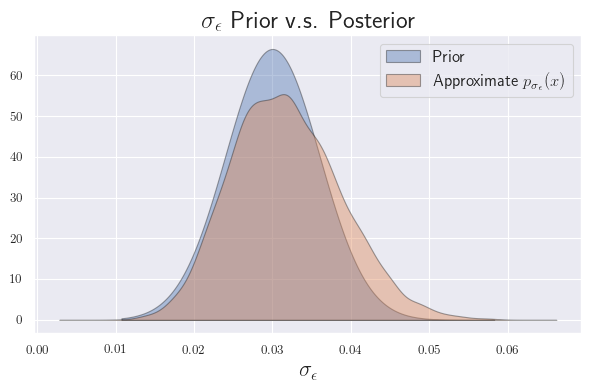

In [436]:
from scipy.stats import norm as normal 
from KDEpy import FFTKDE
from scipy.stats import gaussian_kde

def custom_KDE(data, weights=None, bw=None):
    """ 
    Note that to evaluate pdf of data of dimension > 1 with KDE, we need to first run 
    KDE on a regular grid and then use interpolation to evaluate on arbitrary data points

    check https://kdepy.readthedocs.io/en/latest/examples.html#the-effect-of-norms-in-2d
    and   https://kdepy.readthedocs.io/en/latest/examples.html#fast-evaluation-on-a-non-equidistant-grid
    """
    data = data.flatten()
    if bw is None:
        try:
            sc = gaussian_kde(data, weights=weights)
            bw = np.sqrt(sc.covariance).flatten()
            # Ensure that bw is a scalar value
            if np.size(bw) == 1:
                bw = bw[0]
            else:
                raise ValueError("The bw must be a number.")
        except:
            bw = 1
        if bw < 1e-8:
            bw = 1
    # print('Bandwidth', bw) 
    return FFTKDE(bw=bw).fit(data, weights)

hpr_mean = 0.03
hpr_std = 0.006
pdf_grid = np.linspace(np.min(sig_samples),np.max(sig_samples), 1000)
hpr_pdf = normal.pdf(pdf_grid, hpr_mean, hpr_std)

# KDE estimate
noise_kde = custom_KDE(MCMCSamples2[:,-1])
sgrid, ps = noise_kde.evaluate()
# plot
plt.figure(figsize = (6,4))
plt.fill_between(pdf_grid, hpr_pdf, alpha=0.4, ec='k', label="Prior")
plt.fill_between(sgrid, ps, alpha=0.4, ec='k', label=r"Approximate $p_{\sigma_{\epsilon}}(x)$")
plt.legend(prop={'size':12})
plt.title(r"$\sigma_{\epsilon}$ Prior v.s. Posterior", fontsize=18)
plt.xlabel(r"$\sigma_{\epsilon}$", fontsize=16)
plt.tight_layout()


The experiment for this part is set up as follows. In the fixed-noise case, for every sample of $Z$ we get in 1.(a), we propagate it through the forward model, randomly draw a noise vector from $\mathcal{N}(0,10^{-4} I)$ and add to the forward model evaluation, and record all the $u(0)$ as the posterior prediction. 

In the inferred-noise case, we do the same thing for every sample we get in 1.(b), except that this time we draw the noise vector according to $\mathcal{N}\left(0,\left(\sigma_{\epsilon}^{(i)}\right)^2 I\right)$ where $\sigma_{\epsilon}^{(i)}$ is the last component of the $i$-th sample drawn out of MCMC.

The fixed-noise posterior samples of $u(0)$ are constructed below.

In [422]:
# fixed-noise posterior samples
u0_fixed = []
k_samples = np.exp(y_samples)
ei_sampler = normal(0, 1e-4)
for i in range(k_samples.shape[0]):
    ki = k_samples[i,:]
    ui = sde_solve(ki)
    u0i = ui[0] + ei_sampler.rvs(1).squeeze() # add noise
    u0_fixed.append(u0i)
u0_fixed = np.asarray(u0_fixed)

The KDE-approximated posterior density of $u(0)$ with fixed noise is plotted below.

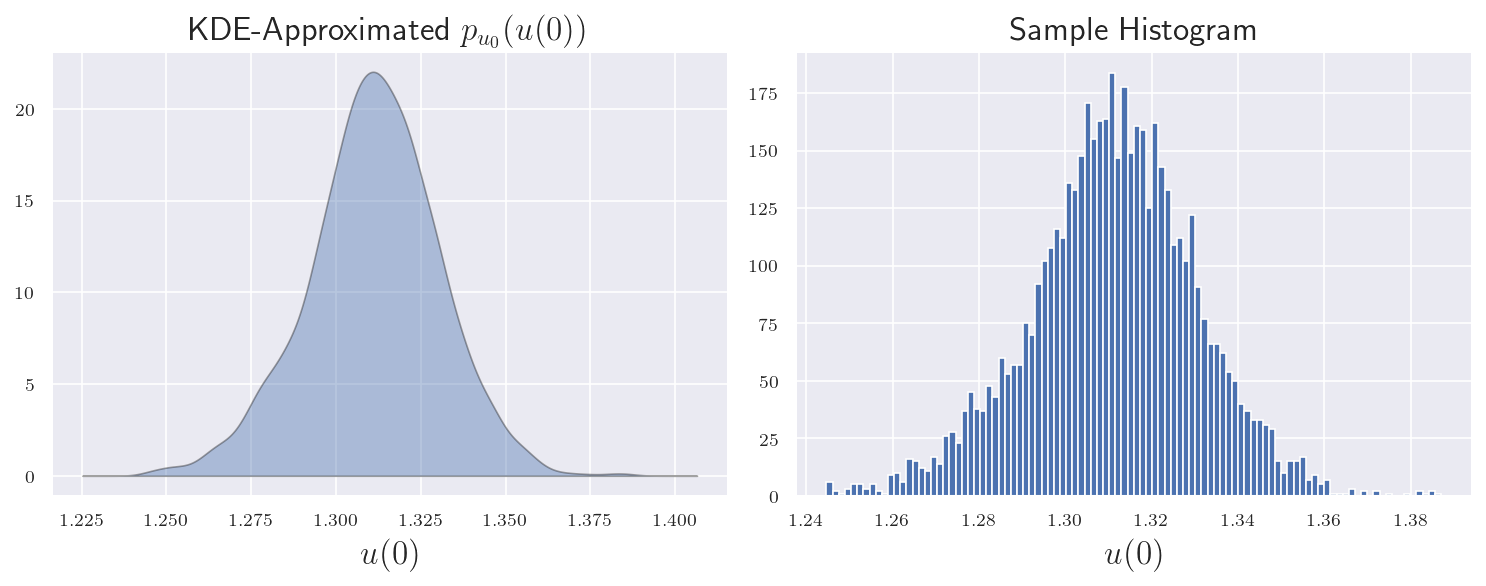

In [456]:
u0_vals, p_u0 = custom_KDE(u0_fixed).evaluate()

# plot
fig,ax = plt.subplots(1,2,dpi = 150,figsize=(10,4))

ax[0].fill_between(u0_vals, p_u0, alpha=0.4, ec='k')
ax[0].set_xlabel(r"$u(0)$", fontsize=16)
ax[0].set_title(r"KDE-Approximated $p_{u_0}(u(0))$", fontsize=16)

ax[1].hist(u0_fixed, bins=100)
ax[1].set_xlabel(r"$u(0)$", fontsize=16)
ax[1].set_title(r"Sample Histogram", fontsize=16)
plt.tight_layout()

The inferred-noise posterior samples of $u(0)$ are constructed below.

In [458]:
# inferred-noise posterior samples
u0_inferred = []
k_samples2 = np.exp(y_samples2)
for i in range(k_samples2.shape[0]):
    ki = k_samples2[i,:]
    ui = sde_solve(ki)
    si = MCMCSamples2[i,-1] # get noise std
    ei_sampler = normal(0, si**2)
    u0i = ui[0] + ei_sampler.rvs(1).squeeze() # add noise
    u0_inferred.append(u0i)
u0_inferred = np.asarray(u0_inferred)

The KDE-approximated posterior density of $u(0)$ with inferred noise is plotted below.

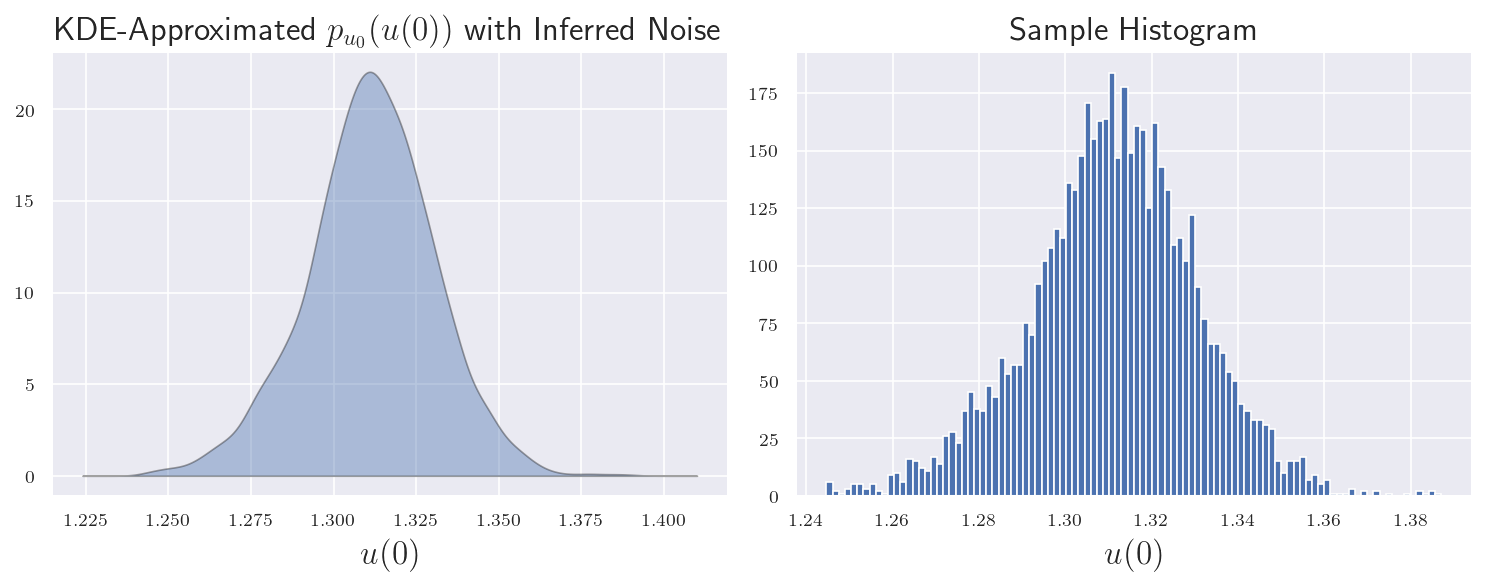

In [455]:
u0_vals_inferred, p_u0_inferred = custom_KDE(u0_inferred).evaluate()

# plot
fig,ax = plt.subplots(1,2,dpi = 150,figsize=(10,4))

ax[0].fill_between(u0_vals_inferred, p_u0_inferred, alpha=0.4, ec='k')
ax[0].set_xlabel(r"$u(0)$", fontsize=16)
ax[0].set_title(r"KDE-Approximated $p_{u_0}(u(0))$ with Inferred Noise", fontsize=16)

ax[1].hist(u0_fixed, bins=100)
ax[1].set_xlabel(r"$u(0)$", fontsize=16)
ax[1].set_title(r"Sample Histogram", fontsize=16)
plt.tight_layout()

## Bayesian Inverse Problem via the Ensemble Kalman Update

In this problem, we seek to approach the Bayesian inverse problem of inferring the posterior distribution $p(Z|y)$ formulated in problem 1.(a) above with the Kalman Filter (KF). Recall that $Z \in \mathbb{R}^r$ is a vector of (truncated) K-L modes where the prior distribution reads $p(Z) \sim \mathcal{N}(0, I)$ and that $y \in \mathbb{R}^N$ is a vector of noisy observations which satisfies
$$
y_i = h_i(Z^*) + \epsilon_i, \forall i
$$
where $Z^*$ is the truth that defines the corresponding dynamics. To make notations consistent with the project instruction, we will use $\theta$ in replacement of $Z$ in the following discussions. 

We first derive an affine prior-to-posterior transformation via the Kalman update formula and apply it to each prior sample $\boldsymbol{\theta}^{(j)}$ in order to generate an approximate posterior ensemble.

Without the presence of the concept of "time" here, in contrast to the cases where KF is mostly commonly used, we will use a single step KF in which the state transition is defined as
$$
\theta_1^{(i)} = \theta_0^{(i)}
$$
and the observation function is given by 
$$
y^{(i)} = h(\theta_0^{(i)}) + \epsilon^{(i)}, \forall i
$$
where $h(\cdot)$ is simply the SDE solver that takes in $\theta_0^{(i)}$ and returns the corresponding SDE solution, $\theta_0^{(i)} \sim \mathcal{N}(0, I)$ are i.i.d., and $\epsilon^{(i)} \sim \mathcal{N}(0,10^{-4}I)$ are i.i.d. Note that here $\theta_0^{(i)}$ are the $Z^{(i)}$ discussed before and the superscript $i$ stands for the $i$-th sample. The reason that the state transition is defined as an identity map is because there is no evolution of state here; i.e., the $\theta_0^{(i)}$ that defines the $i$-th Gaussian Process sample does not change. 

With the above formulation and notations, the goal is translated into the following: we are looking to find a way to update $\theta_0^{(i)}$ to $\theta^{(i)}$ with the given observation $y$ so that the resulting $\theta^{(i)}$ roughly resembles a sample from the true posterior $p(\theta \mid y)$. Since here $h(\cdot)$ is an unknown operator, the closed-form KF is not available. We therefore adopt an ensemble fasion as in the Ensemble Kalman Filter (EnKF) to perform approximate Bayesian inference, which reads as follows.

We first draw $Ns$ samples $\{\theta_0^{(i)}\}_{i=1}^{Ns}$ from $\mathcal{N}(0, I)$, and retrieve the corresponding noisy predictions by 
$$
y^{(i)} = h(\theta_0^{(i)}) + \epsilon^{(i)}.
$$
The forecasting step reads
$$
\theta_1^{(i)} = \theta_0^{(i)}.
$$
It is followed by the analysis step which reads as follows.
1. Compute covariance estimates
$$
\hat{\Sigma}_{\theta Y} = \frac{1}{n-1} \sum_{i=1}^{Ns} (\theta_0^{(i)} - \bar{\theta}_0)(y^{(i)} - \bar{y})^T
$$
and 
$$
\hat{\Sigma}_{Y} = \frac{1}{n-1} \sum_{i=1}^{Ns} (y^{(i)} - \bar{y})(y^{(i)} - \bar{y})^T.
$$
2. Compute the estimated Kalman Gain matrix 
$$
\hat{G} = \hat{\Sigma}_{\theta Y} \hat{\Sigma}_{Y}^{-1}. 
$$
3. Compute the Kalman update 
$$
\theta^{(i)} = \theta_0^{(i)} + \hat{G}(y - y^{(i)}).
$$

These together give the desired Kalman update formula. The algorithm is implemented below



In [18]:
def EnKF(r, Ns):
    """ 
    r : number of KL modes (stochastic dimension)
    Ns : number of samples
    """
    # define prior and noise samplers
    prior_sampler = mvn(np.zeros((r,)), np.eye(r))
    eps_sampler = mvn(np.zeros((10,)), 1e-4*np.eye(10))

    # prior samples
    theta0_samples = prior_sampler.rvs(Ns).reshape((Ns,-1))

    # store yi
    y_samples = np.zeros((Ns, 10)) # (Ns, 10)

    # store results
    samples = np.zeros((Ns, r))

    # simulate observations
    for i in range(Ns):
        theta0_i = theta0_samples[i,:]
        ki = get_k(theta0_i)
        ui_temp = sde_solve(ki)
        ui = np.asarray([
            ui_temp[15*k] for k in range(10)
        ])
        ei = eps_sampler.rvs(1).reshape(ui.shape)
        yi = ui+ei
        y_samples[i,:] = yi.squeeze()
    
    # Estimate covs
    theta0_bar = np.mean(theta0_samples, axis=0)
    y_bar = np.mean(y_samples, axis=0)
    Sty = 1 / Ns * (theta0_samples - theta0_bar).T @ (y_samples - y_bar)
    Sy = np.cov(y_samples, rowvar=False)

    # Kalman update
    for i in range(Ns):
        theta0_i = theta0_samples[i,:]
        yi = y_samples[i,:]
        theta_i = theta0_i + (Sty @ np.linalg.solve(Sy, (u_observed - yi).reshape(-1,1))).reshape((-1,))
        samples[i,:] = theta_i

    return samples

In [19]:
# run EnKF
r = 15
Ns = 10000
KFSamples = EnKF(r,Ns)

Below we plot the inferred log permeability and the inferred solution. We see that we obtained a decent but less-accurate-than-MCMC inference result.

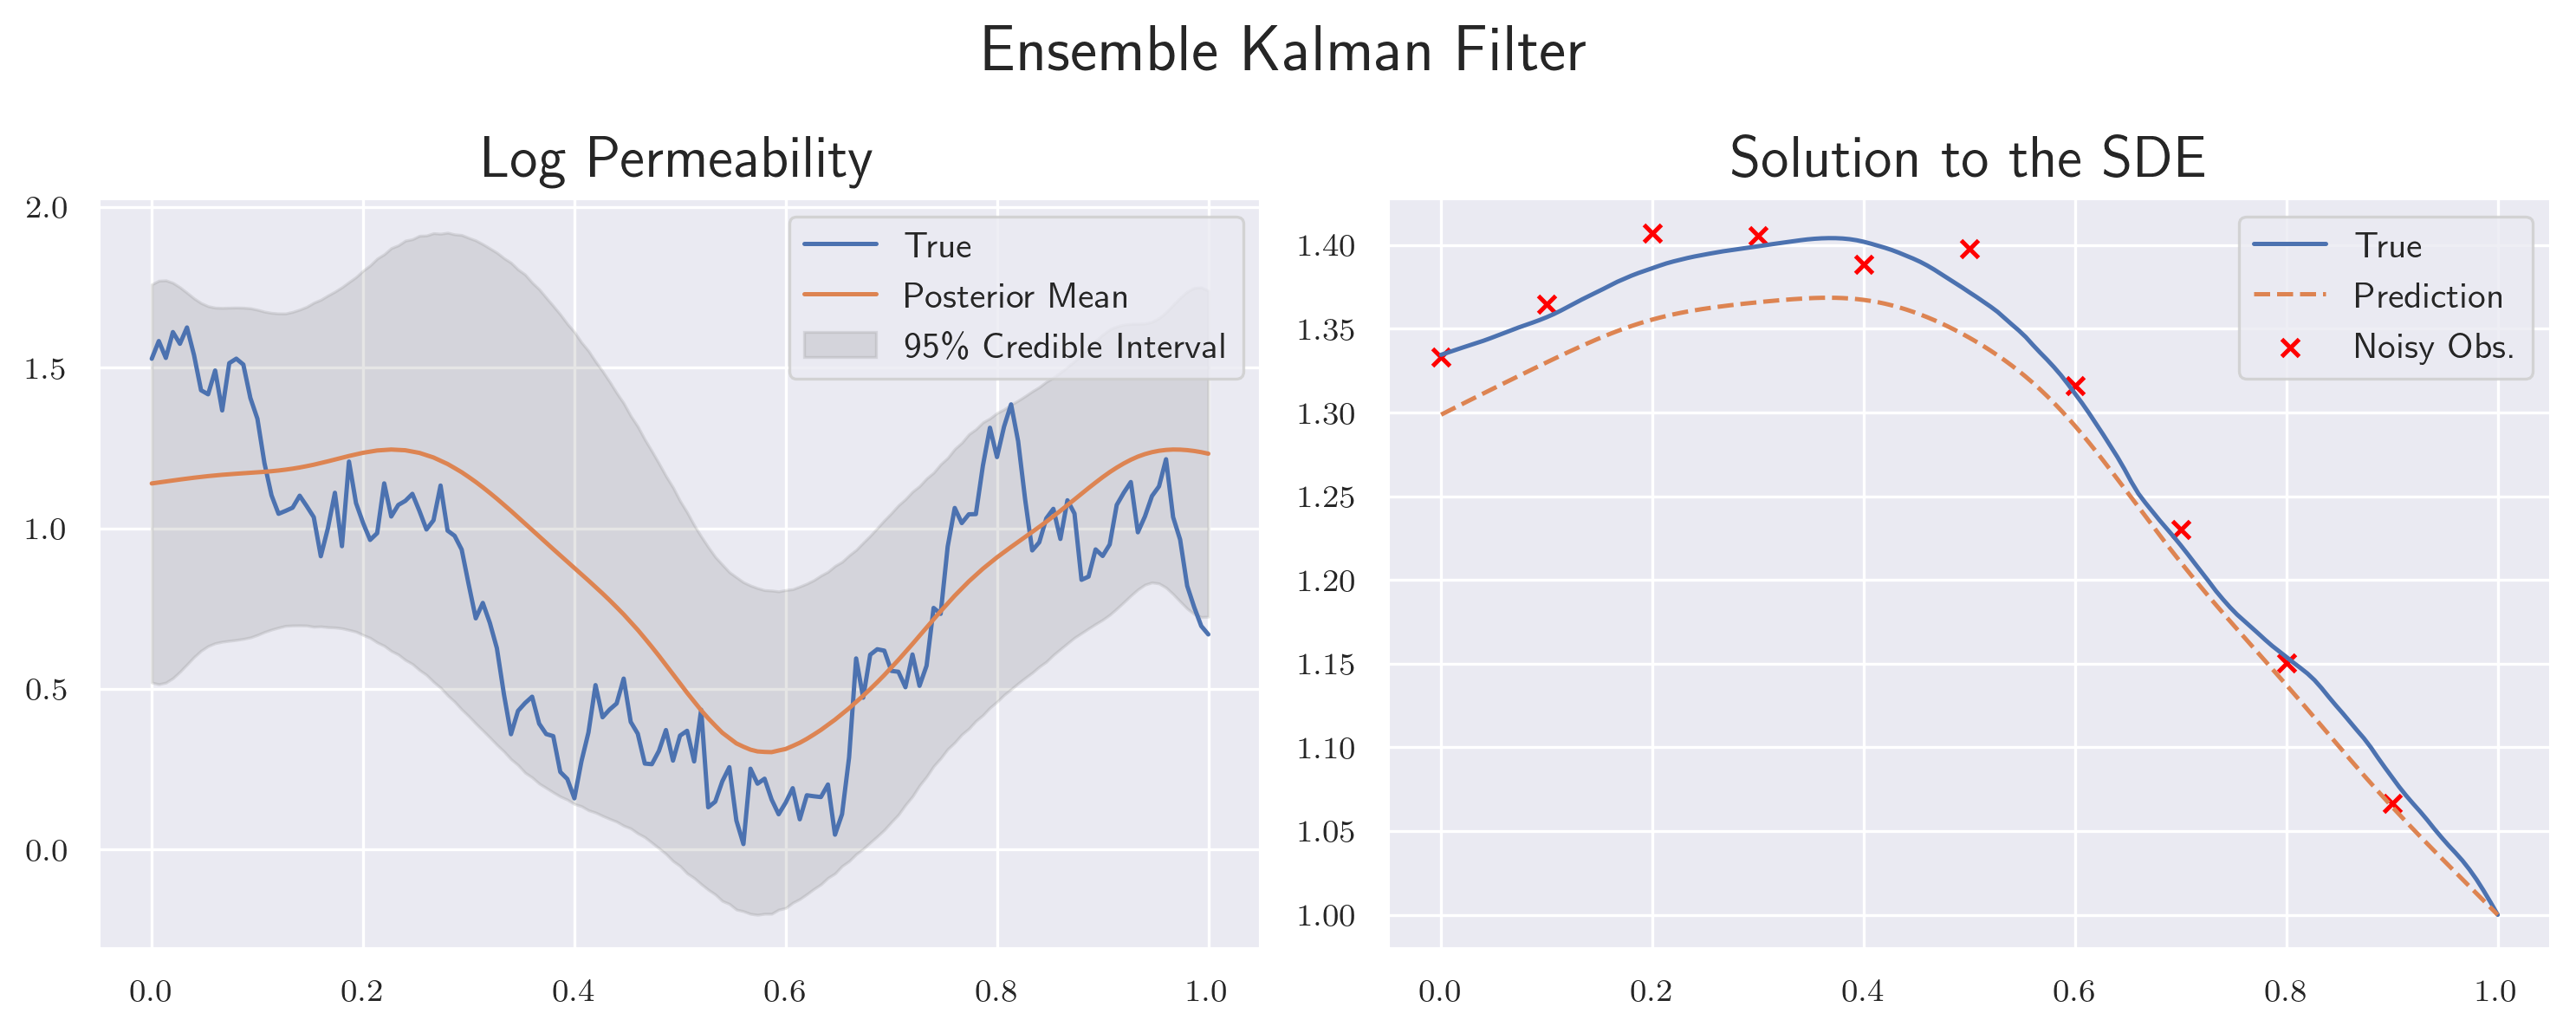

In [20]:
mu = 1
kle = default_KLE(r)
y_samples_enkf = np.zeros((KFSamples.shape[0], xgrid.shape[0]))
for i in range(KFSamples.shape[0]-1):
    Zi = KFSamples[i,:]
    yi = mu + eval_KLE(kle,xgrid,Zi)
    y_samples_enkf[i,:] = yi
y_std = np.std(y_samples_enkf, axis=0)

theta_mean = np.average(KFSamples, axis=0)
y_pred = mu + eval_KLE(kle, xgrid, theta_mean)
k_pred = np.exp(y_pred)
u_true = sde_solve(ktrue)
u_pred = sde_solve(k_pred)

# plot
fig,ax = plt.subplots(1,2,dpi = 300,figsize=(10,4))
ax[0].plot(xgrid, np.log(ktrue), label='True ')
ax[0].plot(xgrid, y_pred, label='Posterior Mean')
ax[0].fill_between(xgrid, y_pred-1.96*y_std, y_pred+1.96*y_std, alpha=0.2, color="gray", label="95\% Credible Interval")
ax[0].set_title("Log Permeability", fontsize=16)
ax[0].legend(prop={'size': 10})

ax[1].plot(xgrid, u_true, label='True')
ax[1].plot(xgrid, u_pred, '--', label='Prediction')
ax[1].scatter(x_observed, u_observed, marker='x',label='Noisy Obs.', color='red')
ax[1].set_title('Solution to the SDE', fontsize=16)
ax[1].legend(prop={'size': 10})

plt.suptitle("Ensemble Kalman Filter", fontsize=18)
plt.tight_layout()

Below, we compare the sample covariance of the EnKF samples with that of the MCMC samples generated in 1.(a). The covariance matrices are plotted on the same scale. We see that both the covariance matrices have concentrated values on the diagonal. As it gets away from the diagonal, we see that both matrices have most entries close to zero and occassionally have bumps. However, the MCMC one has a much rougher landscape than the EnKF one.

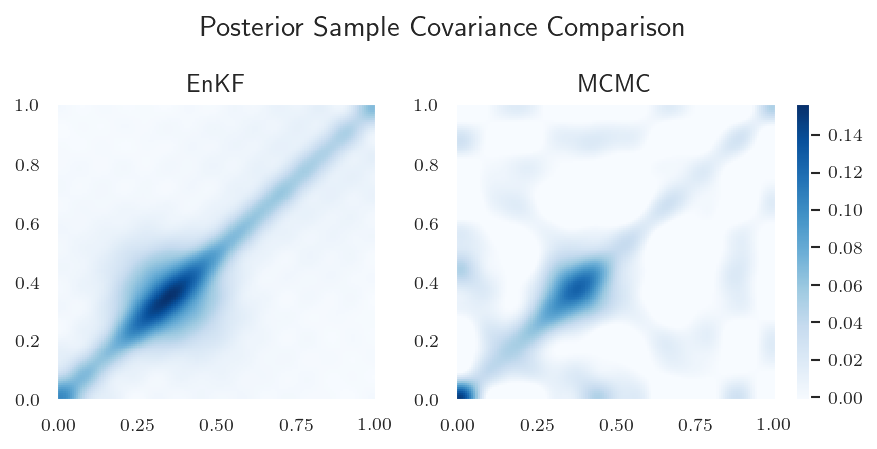

In [21]:
# mcmc posterior sample covariance
cov_mcmc = np.cov(y_samples, rowvar=False)

# EnKF posterior sample covariance
cov_enkf = np.cov(y_samples_enkf, rowvar=False)

# plot
fig, ax = plt.subplots(1,2, figsize = (6,3), dpi=150, 
                       gridspec_kw={'width_ratios': [4, 5]})

plt2 = ax[0].pcolormesh(xgrid, xgrid, cov_enkf, cmap="Blues")
cbar = fig.colorbar(plt2)
ax[0].set_title(fr"EnKF", fontsize=12)

# covariacne
plt3 = ax[1].pcolormesh(xgrid, xgrid, cov_mcmc, cmap="Blues")
cbar2 = fig.colorbar(plt3)
cbar2.mappable.set_clim(*cbar.mappable.get_clim()) # set on the same scale
cbar.remove() # remove the first color bar
ax[1].set_title("MCMC", fontsize=12)

plt.suptitle(r"Posterior Sample Covariance Comparison", fontsize=14)
plt.tight_layout()

With the EnKF samples, component-wise sample approximate marginal densities based on Kernel Density Estimation and pair-wise scatter plots are presented below for $Z_1$ through $Z_6$. Compared to the MCMC samples in 1.(a), which we plotted again below. We see that the marginal distributions may look similar, the correlations between different variables can vary a lot. For instance, $Z_1$ and $Z_2$ in the MCMC samples are much more correlated than those in the EnKF samples.

Text(0.5, 0.98, 'Ensemble Kalman Filter')

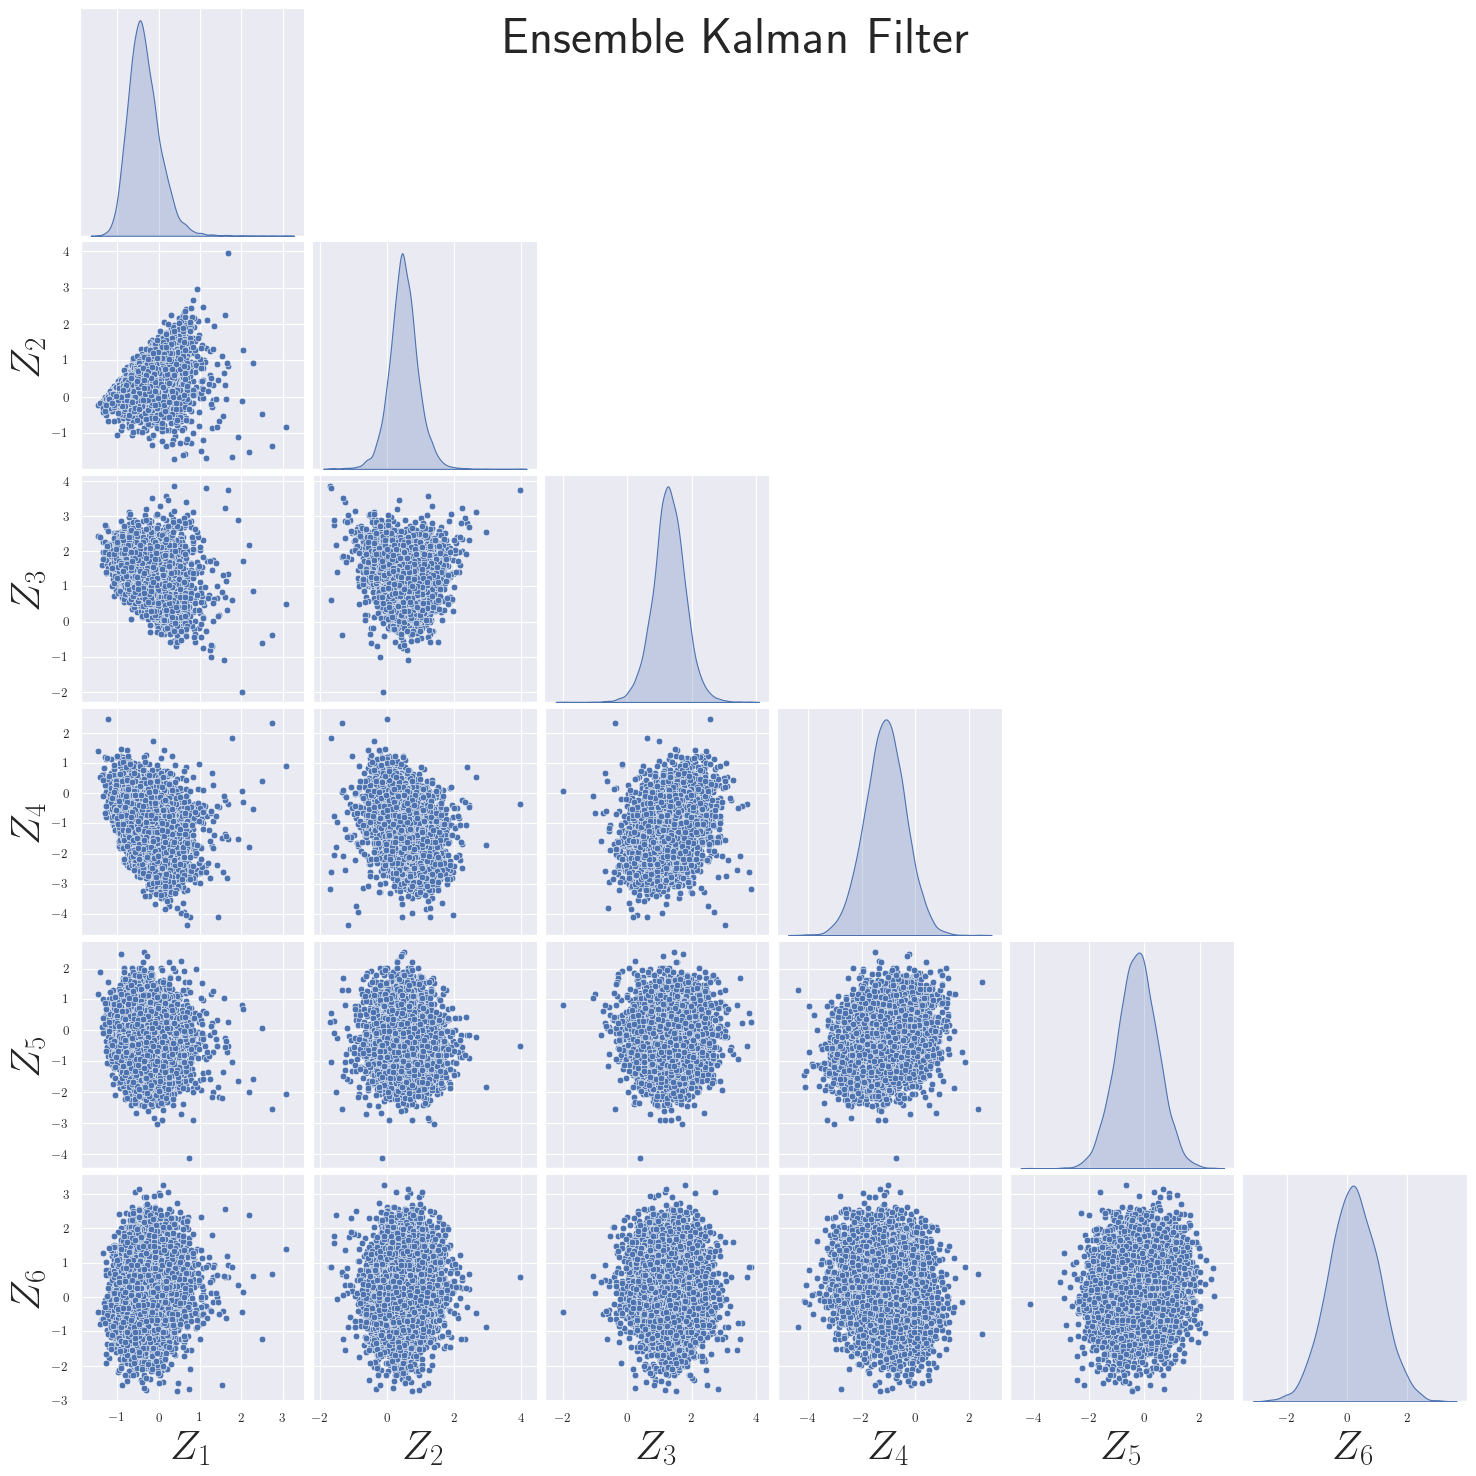

In [22]:
sns.set_context("paper", rc={"axes.labelsize":30})
df_enkf = pd.DataFrame({
    r'$Z_1$' : KFSamples[:,0],
    r'$Z_2$' : KFSamples[:,1],
    r'$Z_3$' : KFSamples[:,2],
    r'$Z_4$' : KFSamples[:,3],
    r'$Z_5$' : KFSamples[:,4],
    r'$Z_6$' : KFSamples[:,5]
})
g = sns.pairplot(df_enkf, corner=True, diag_kind='kde')
g.fig.suptitle("Ensemble Kalman Filter", fontsize=36)


Text(0.5, 0.98, 'Adaptive Metropolis-Hastings')

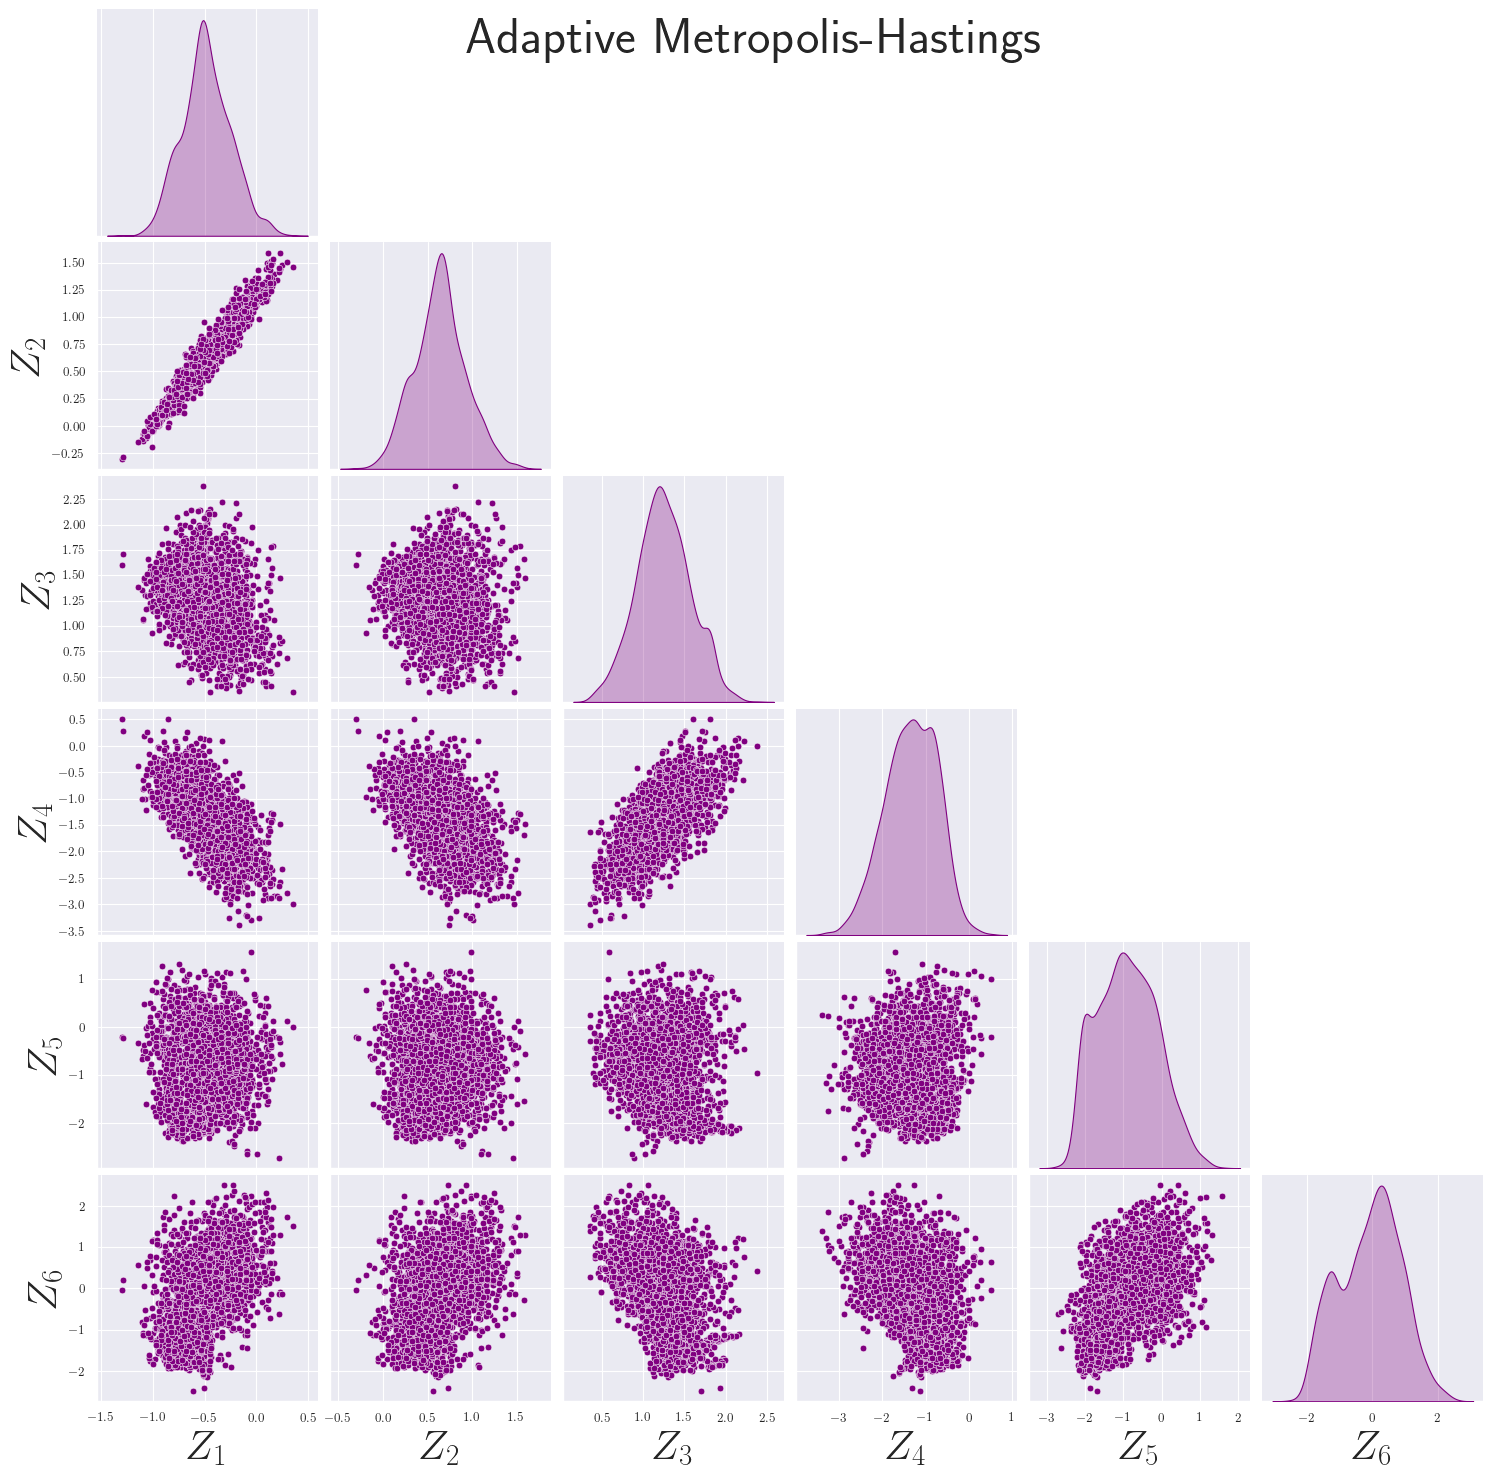

In [42]:
g = sns.pairplot(df_mcmc, corner=True, diag_kind='kde', 
                 plot_kws={'color' : "purple"}, 
                 diag_kws={'color' : "purple",
                           'alpha' : 0.3})
g.fig.suptitle("Adaptive Metropolis-Hastings", fontsize=36)

## Ensemble Filtering

The Lorenz-63 model is a three-dimensional nonlinear dynamical system (first introduced by Edward Lorenz in a famous 1963 paper) that describes the natural convection of a heated fluid. The state at time $t$ is a three-dimensional vector $\boldsymbol{Z}(t)=\left(Z_1(t), Z_2(t), Z_3(t)\right)$ whose dynamics are given by the ODE system,

$$
\begin{array}{rr}
\frac{d Z_1}{d t}= & -\sigma Z_1+\sigma Z_2 \\
\frac{d Z_2}{d t}= & -Z_1 Z_3+\rho Z_1-Z_2 \\
\frac{d Z_3}{d t}= & Z_1 Z_2-\beta Z_3
\end{array}
$$

where $(\beta, \rho, \sigma)$ are fixed parameters. We will set $\beta=8 / 3, \rho=28$, and $\sigma=10$, which produces chaotic solutions tending to the well-known Lorenz attractor. To make notation more compact, we will write the ODE system above simply as

$$
\frac{d \boldsymbol{Z}}{d t}=f(\boldsymbol{Z})
$$


In this problem, we will experiment with an algorithm for nonlinear filtering. To set up the filtering problem, we will fix an assimilation time interval $\Delta t_{\text {obs }}$ and index the state at discrete observation times as $\left(\boldsymbol{Z}_k\right)_{k \geq 1}$, where $\boldsymbol{Z}_k=\boldsymbol{Z}\left(k \Delta t_{\text {obs }}\right)$. For any observation step $k$, we will observe the entire state (i.e., all three components) perturbed with additive Gaussian noise. The observation model is thus $\boldsymbol{Y}_k \sim \mathcal{N}\left(\boldsymbol{Z}_k, \sigma^2 \boldsymbol{I}_3\right)$. Set $\sigma^2=4$.

To assess the performance of the filtering algorithms developed below, we will use the socalled "identical twin experiment" setting: a single trajectory $\boldsymbol{z}^*(t)$ of the system, starting from an arbitrarily chosen initial condition, is observed every $\Delta t_{\text {obs }}$ time units and perturbed with noise (according to the observation model) to create a sequence of synthetic observations $\left\{\boldsymbol{y}_k^*\right\}_{k \geq 1}$. These observations, along with an initial ensemble at time $t=0$, serve as inputs to the filtering algorithm. The filter then produces sample approximations to the sequence of posterior distributions $\left\{p\left(\boldsymbol{Z}_k \mid \boldsymbol{y}_{1: k}^*\right)\right\}_{k \geq 1}$. Depending on the form of the filter, this sample approximation might involve non-uniform weights (as in a particle filter) or no weights (effectively, uniform weights, as in the ensemble Kalman filter).

From outputs of a filtering algorithm, we can estimate the posterior mean $\mathbb{E}\left[\boldsymbol{Z}_k \mid \boldsymbol{y}_{1: k}^*\right]$, the posterior covariance $\operatorname{Cov}\left(\boldsymbol{Z}_k \mid \boldsymbol{y}_{1: k}^*\right)$, or any other expectations at each step $k$. For instance, the ensemble mean $\overline{\boldsymbol{z}}_k:=\sum_{i=1}^M \boldsymbol{z}_k^{(i)} \approx \mathbb{E}\left[\boldsymbol{Z}_k \mid \boldsymbol{y}_{1: k}^*\right]$ (which might be weighted in, e.g., the particle filtering case) serves as a convenient point estimate of the true state $\boldsymbol{Z}_k^*$. One can then evaluate the "tracking" performance of such an estimator via the root-mean-squared error (RMSE), defined at any assimilation step $k$ as $\operatorname{RMSE}_k:=\left\|\bar{z}_k-\boldsymbol{z}_k^*\right\|_2 / \sqrt{3}$. A useful result to report is then RMSE $_k$ averaged over a large number of assimilation steps (e.g., several thousand), following a spin-up period (see below). This provides an overall quantification of how well the ensemble/sample mean tracks the true state. However, since this only models how well the first moment is captured, it's vital to also at least report the distribution of time-averaged RMSE performance over several different experiments.

We first implement the ODE integrator with the help of `scipy.integrate.solve_ivp`. We choose the initial condition as $[0,.5,0]^T$, and the time interval as $[0,50]$. The true trajectory is then corrupted with i.i.d. noise drawn from $\mathcal{N}(0, 4I)$ at each time step.

In [10]:
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal as mvn 
# ode params
beta = 8/3
rho = 28.
sig = 10.

def f63(t,Z):
    Z1 = Z[0]
    Z2 = Z[1]
    Z3 = Z[2]
    fz = np.asarray([
        -sig*Z1 + sig*Z2,
        -Z1*Z3 + rho*Z1 - Z2,
        Z1*Z2 - beta*Z3
    ])
    return fz

def Lorenz63(tsteps, z0):
    tspan = [np.min(tsteps), np.max(tsteps)]
    sol = solve_ivp(f63, tspan, z0, t_eval=tsteps)
    Z = sol.y
    return Z.T

# forward model
def L63_1step(tobs,z):
    tspan = [0,tobs]
    teval = np.linspace(0,tobs,5)
    sol = solve_ivp(f63, tspan, z, t_eval=teval)
    return sol.y[:,-1]

In [38]:
t0 = 0.
t1 = 100+1e-6
dt = 0.0025
tsteps = np.arange(t0,t1,step=dt)
nt = tsteps.shape[0]
z0 = [0,.5,0]

# solve ODE
Ztrue = Lorenz63(tsteps, z0)

# Sample iid noise
eps_sampler = mvn(np.zeros((3,)), 4*np.eye(3))
Noise = eps_sampler.rvs(nt)

# create obs.
Zobs = Ztrue + Noise

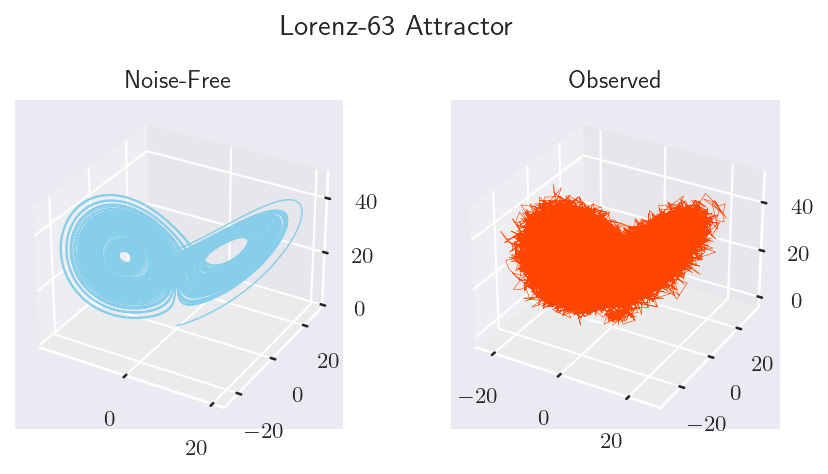

In [39]:
# Plot attractors
fig = plt.figure(figsize = (6,3), dpi=150)
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot(Ztrue[:,0],Ztrue[:,1],Ztrue[:,2], color='skyblue', linewidth = 0.7)
ax.set_title("Noise-Free", fontsize=12)

ax = fig.add_subplot(1,2,2,projection='3d')
ax.plot(Zobs[:,0],Zobs[:,1],Zobs[:,2], linewidth = 0.3, color='orangered')
ax.set_title("Observed", fontsize=12)

plt.suptitle("Lorenz-63 Attractor", fontsize=14)
plt.tight_layout()

The EnKF for filtering the noisy Lorenz-63 attractor is implemented below. The initial ensemble is sampled from $\mathcal{N}(0,I)$. The forward model is propagated by using the same ODE solver for constructing the true and observed states.

In [30]:
def EnKF2(Z0, tobs):
    """ 
    X0 : initial ensemble (M, 3)
    tobs : observation interval
    """    
    # forecast: run Xa_prev thru forward model and add noise -> Xf_curr
    tsteps = np.arange(tobs,t1,tobs)

    # initialize the analysis ensemble
    Za = Z0

    # store ensemble mean at each time step
    Z_filtered = np.zeros((tsteps.shape[0], 3))
    for k,t in enumerate(tsteps):
        # retrieve observation
        tidx = int(np.round(t/dt))
        Zt_obs = Zobs[tidx,:]

        # forward model
        Zf = np.zeros_like(Za)
        for i in range(Za.shape[0]):
            Za_i = Za[i,:]
            Zf_i = L63_1step(tobs,Za_i)
            Zf[i,:] = Zf_i

        # compute sample cov from Xt forecast
        Cf = np.cov(Zf, rowvar=False)

        # Kalman gain: G = Cf @ (Cf + 4I)^{-1} (H=Id)
        S = Cf + 4*np.eye(3)

        # analysis: Xa = Xf + G@(Zobs_t - (Xf_t + et))
        for i in range(Za.shape[0]):
            Zf_i = Zf[i,:]
            Zf_pert_i = Zf_i + eps_sampler.rvs(1).reshape((-1,))
            Za_i = Zf_i + ( Cf @ np.linalg.solve(S, (Zt_obs-Zf_pert_i).reshape(-1,1)) ).reshape((-1,))
            Za[i,:] = Za_i
        
        # record filtered state
        Z_filtered[k,:] = np.mean(Za,axis=0)

    return Z_filtered

We test the filtering algorithm below and plot the filtered trajectory. Here we choose $\Delta t_{\text{obs}} = 0.04$ and use an ensemble of size 20. 

In [40]:
# run EnKF
M = 20
mult = 16
tobs = mult*dt
ktrunc = int(np.round(tsteps.shape[0]/mult/2))
Z0 = np.random.randn(M,3)
Zfilt = EnKF2(Z0, tobs)

# post-processing
Zfilt_trunc = Zfilt[ktrunc:,:]
Ztrue_trunc = Ztrue[mult:,:][::mult,:][ktrunc:,:]

The true trajectory and the filtered trajectory are plotted below. We see that the previously noisy mess is denoised into a decent state and approximates the truth well.

In [41]:
# Plot filtered attractors
fig = plt.figure(figsize = (3.5,3.5), dpi=150)
ax = fig.add_subplot(projection='3d')
ax.plot(Ztrue_trunc[:,0],Ztrue_trunc[:,1],Ztrue_trunc[:,2], linewidth = 1, color='skyblue', label="True")
ax.plot(Zfilt_trunc[:,0],Zfilt_trunc[:,1],Zfilt_trunc[:,2], linewidth = 0.5, color='orangered', label="Filtered")
ax.legend(prop={'size': 10})
ax.set_title("Lorenz-63 Attractor", fontsize=12)
plt.tight_layout()

In the next experiment, we investigate the influence of the ensemble size on the performance of EnKF by measuring the root-mean-squared error (RMSE). For each tested ensemble size, we run the experiments for 10 independent times, record the RMSE, and compute the mean and standard deviation of the RMSE after all 10 experiments are done. We choose the ensemble size to range from 5 to 50 with a step size of 5.

In [50]:
Mlist = [
    5 * k for k in range(1,11)
]
mult = 32
tobs = mult*dt
ktrunc = int(np.round(tsteps.shape[0]/mult/2))
nrun = 10
RMSE_mean = []
RMSE_std = []
for M in Mlist:
    rmse_temp = []
    for _ in range(nrun):
        Z0 = np.random.randn(M,3)
        Zfilt = EnKF2(Z0, tobs)
        Zfilt_trunc = Zfilt[ktrunc:,:]
        Ztrue_trunc = Ztrue[mult:,:][::mult,:][ktrunc:,:]
        temp = np.sum((Zfilt_trunc-Ztrue_trunc)**2,axis=1) / 3
        rmse = np.mean(np.sqrt(temp))
        rmse_temp.append(rmse)
    rmse_temp = np.asarray(rmse_temp)
    RMSE_mean.append(np.mean(rmse_temp))
    RMSE_std.append(np.std(rmse_temp))

Below we plot the RMSE mean and 95% confidence interval over the 20 independent experiments.

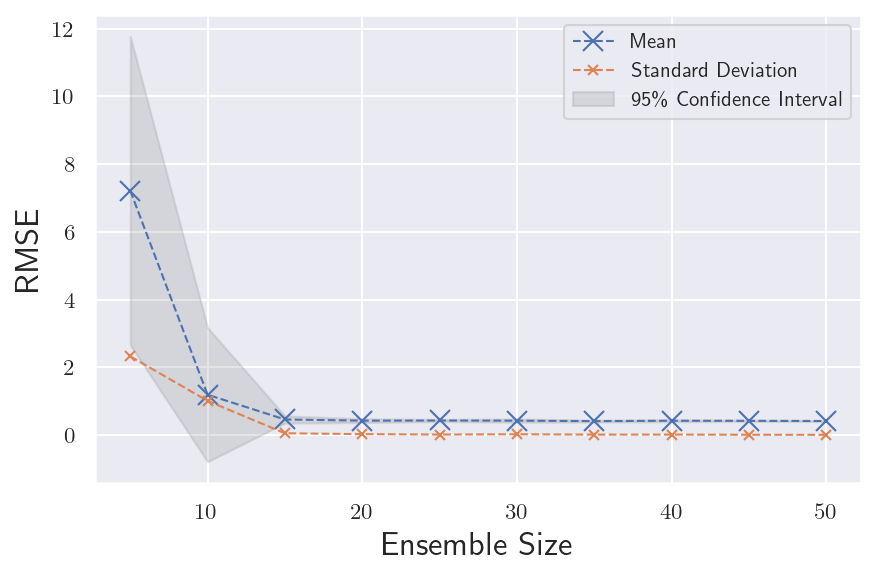

In [59]:
RMSE_mean = np.asarray(RMSE_mean)
RMSE_std = np.asarray(RMSE_std)
plt.figure(figsize=(6,4),dpi=150)
plt.plot(Mlist, RMSE_mean, '--x', markersize=10, linewidth=1, label='Mean')
plt.plot(Mlist, RMSE_std, '--x', markersize=5, linewidth=1, label='Standard Deviation')
plt.fill_between(Mlist, RMSE_mean-1.96*RMSE_std, RMSE_mean+1.96*RMSE_std, alpha=0.2, color="gray", label="95\% Confidence Interval")
plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Ensemble Size", fontsize=16)
plt.legend(prop={'size': 10})
plt.tight_layout()

In the next experiment, we investigate the effect of $\Delta t_{\text{obs}}$ on EnKF again by measuring the RMSE. We choose $\Delta t_{\text{obs}} \in \{0.04,0.08,0.16,0.32\}$. We first visualize the attractors below. 

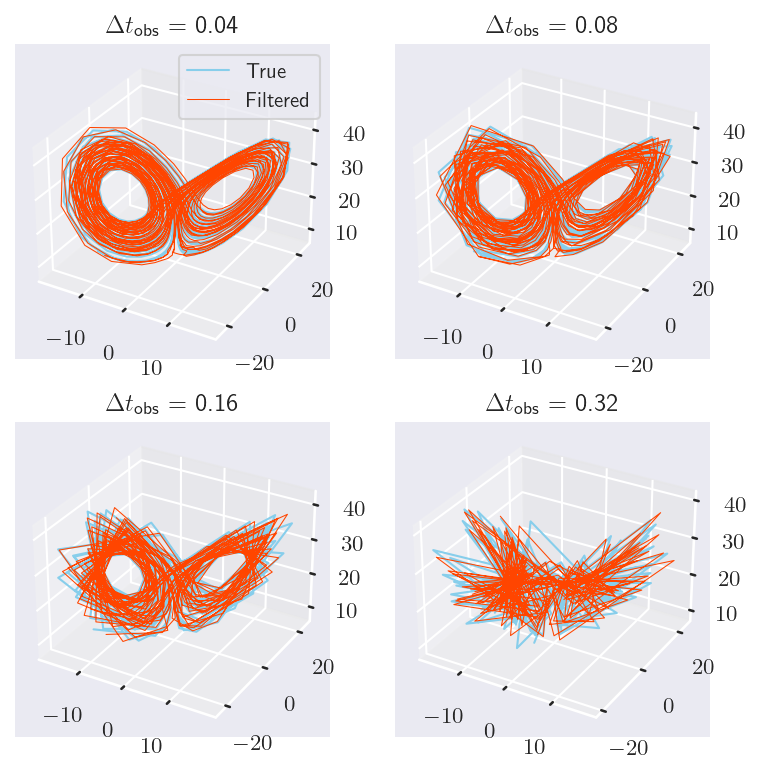

In [46]:
mult_list = [
    2**k for k in range(4,8)
]
tobs_list = [mult*dt for mult in mult_list]
M = 20
RMSE2 = []

# plot attractors
fig = plt.figure(figsize = (6,6), dpi=150)
for i,mult in enumerate(mult_list):
    tobs = mult*dt
    ktrunc = int(np.round(tsteps.shape[0]/mult/2))
    Z0 = np.random.randn(M,3)
    Zfilt = EnKF2(Z0, tobs)
    Zfilt_trunc = Zfilt[ktrunc:,:]
    Ztrue_trunc = Ztrue[mult:,:][::mult,:][ktrunc:,:]
    temp = np.sum((Zfilt_trunc-Ztrue_trunc)**2,axis=1) / 3
    rmse = np.mean(np.sqrt(temp))
    RMSE2.append(rmse)

    # plot
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    ax.plot(Ztrue_trunc[:,0],Ztrue_trunc[:,1],Ztrue_trunc[:,2], linewidth = 1, color='skyblue', label="True")
    ax.plot(Zfilt_trunc[:,0],Zfilt_trunc[:,1],Zfilt_trunc[:,2], linewidth = 0.5, color='orangered', label="Filtered")
    if i==0:
        ax.legend(prop={'size':10})
    ax.set_title(r"$\Delta t_{\text{obs}}$"+f" = {tobs_list[i]}", fontsize=12)

Similar to the previous case, for each $\Delta t_{\text{obs}}$, we run 10 independent experiments, record the RMSE for each of them, and compute the mean and variance. Here we choose an ensemble size of 15. The procedure is done below.

In [56]:
nrun = 10
RMSE_mean2 = []
RMSE_std2 = []
mult_list = [
    2**k for k in range(4,8)
]
tobs_list = [mult*dt for mult in mult_list]
M = 15

# plot attractors
for i,mult in enumerate(mult_list):
    tobs = mult*dt
    ktrunc = int(np.round(tsteps.shape[0]/mult/2))
    rmse_temp = []
    for _ in range(nrun):
        Z0 = np.random.randn(M,3)
        Zfilt = EnKF2(Z0, tobs)
        Zfilt_trunc = Zfilt[ktrunc:,:]
        Ztrue_trunc = Ztrue[mult:,:][::mult,:][ktrunc:,:]
        temp = np.sum((Zfilt_trunc-Ztrue_trunc)**2,axis=1) / 3
        rmse = np.mean(np.sqrt(temp))
        rmse_temp.append(rmse)
    rmse_temp = np.asarray(rmse_temp)
    RMSE_mean2.append(np.mean(rmse_temp))
    RMSE_std2.append(np.std(rmse_temp))

RMSE_mean2 = np.asarray(RMSE_mean2)
RMSE_std2 = np.asarray(RMSE_std2)

Below we plot the RMSE against $\Delta t_{\text{obs}}$. We see that the RMSE increases as the length of the observation time interval increases, which makes sense intuitively.

In [62]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(tobs_list, RMSE_mean2, '--+', markersize=16, linewidth=1, label='Mean')
plt.plot(tobs_list, RMSE_std2, '--x', markersize=5, linewidth=1, label='Standard Deviation')
plt.fill_between(tobs_list, RMSE_mean2-1.96*RMSE_std2, RMSE_mean2+1.96*RMSE_std2, alpha=0.2, color="gray", label="95\% Confidence Interval")
plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Ensemble Size", fontsize=16)
plt.legend(prop={'size': 10})
plt.tight_layout()